In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt
from itertools import product as outer
import scipy.stats as stats
import seaborn as sns
from theano import sparse

%matplotlib inline

# Utility Methods

In [49]:
def gamma_reparam(mu, sd):
    alpha = mu**2/sd**2
    scale  = sd**2/mu

    return alpha, scale

# Load Data

In [2]:
data = pd.read_table("tmuris.coverage.partial.clean800.tsv.gz")
data.head()

,chromosome,position,counts,batch,gene,txEnd,distance
0,chr11,84401150,1,SRR6835844,Acaca,84401664,514
1,chr11,84401159,1,SRR6835844,Acaca,84401664,505
2,chr11,84401160,1,SRR6835844,Acaca,84401664,504
3,chr11,84401176,1,SRR6835844,Acaca,84401664,488
4,chr11,84401188,1,SRR6835844,Acaca,84401664,476


## Format Input Data

In [6]:
G = data.gene.nunique()
B = data.batch.nunique()

# Gene predictor
gene_dummies = pd.get_dummies(data.gene)
gene_coords = gene_dummies.columns.values.tolist()
X_g = gene_dummies.values

# Batch predictor
batch_dummies = pd.get_dummies(data.batch)
batch_coords = batch_dummies.columns.values.tolist()
X_b = batch_dummies.values

X = np.concatenate((X_g, X_b), axis=1)

# Response
Y = data.distance.values.astype(np.float)
W = data.counts.values.astype(np.float)


## Gene-Aggregated Data
data_agg_g = data.groupby(['gene', 'distance']).agg({'counts': 'sum'}).reset_index()

gene_agg_dummies = pd.get_dummies(data_agg_g.gene)
gene_agg_coords = gene_agg_dummies.columns.values.tolist()

X_agg_g = gene_agg_dummies.values
Y_agg_g = data_agg_g.distance.values.astype(np.float)
W_agg_g = data_agg_g.counts.values.astype(np.float)


## Batch-Aggregated Data
data_agg_b = data.groupby(['batch', 'distance']).agg({'counts': 'sum'}).reset_index()

batch_agg_dummies = pd.get_dummies(data_agg_b.batch)
batch_agg_coords = batch_agg_dummies.columns.values.tolist()

X_agg_b = batch_agg_dummies.values
Y_agg_b = data_agg_b.distance.values.astype(np.float)
W_agg_b = data_agg_b.counts.values.astype(np.float)

# Fixed Effects
## Aggregated Batches

In [19]:
with pm.Model() as fixed_effects_batch_gamma_regression:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=B)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    
    # regression functions
    mu = mu_all + pm.math.dot(X_agg_b, beta)
    
    y = pm.Potential('y_logp_weighted', W_agg_b*pm.Gamma.dist(mu=mu, sd=sigma_all).logp(Y_agg_b))
    
    vi_fe_b_gr = pm.fit(method='advi', n=100000,
                        callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 4.8829e+07: 100%|██████████| 100000/100000 [06:09<00:00, 271.00it/s]
Finished [100%]: Average Loss = 4.8829e+07


### Loss Plot

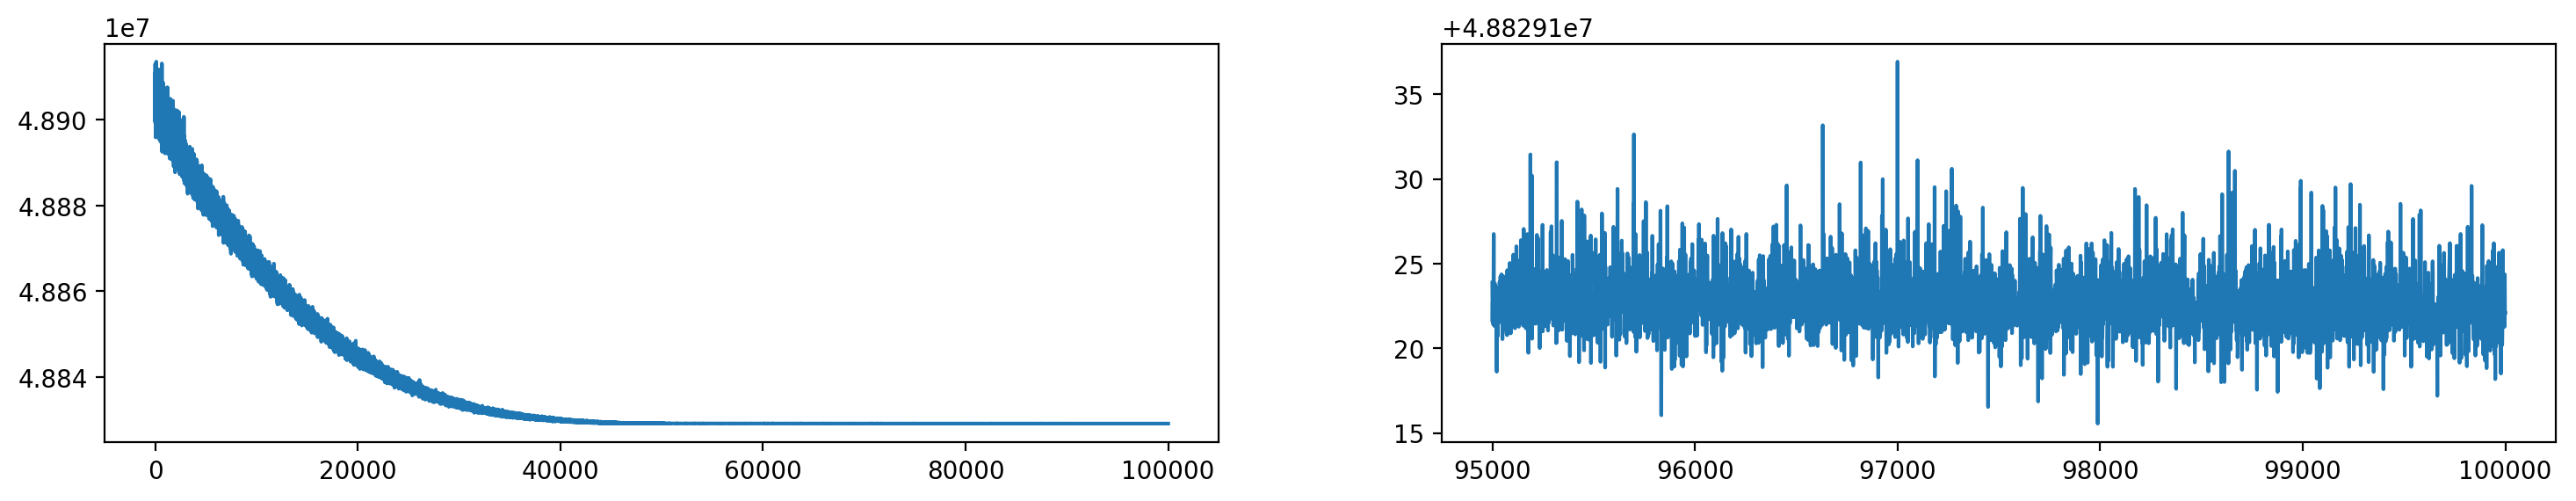

In [28]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(vi_fe_b_gr.hist)

plt.subplot(1,2,2)
plt.plot(np.arange(95000,100000), vi_fe_b_gr.hist[95000:])
plt.show()

It appears that it is mostly converged.

In [42]:
sample_fe_b_gr = vi_fe_b_gr.sample(2000)
pm.summary(sample_fe_b_gr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_all,270.020487,0.028326,0.000632,269.965649,270.074751
beta__0,0.827107,0.154450,0.003325,0.532585,1.131609
beta__1,5.079520,0.133025,0.002711,4.796758,5.319589
beta__2,-10.957178,0.162226,0.003409,-11.268344,-10.637017
beta__3,-9.231999,0.121817,0.002699,-9.478646,-9.000155
beta__4,-6.028644,0.130790,0.002756,-6.300313,-5.780804
beta__5,-11.864065,0.134846,0.002975,-12.105531,-11.575890
beta__6,-12.021980,0.164085,0.003191,-12.321986,-11.674306
beta__7,-16.509202,0.146068,0.003586,-16.768618,-16.199351
beta__8,-5.692789,0.187814,0.004120,-6.059528,-5.327902


In [45]:
traz_fe_b_gr = az.from_pymc3(trace=sample_fe_b_gr,
                             coords={'batch': batch_agg_coords},
                             dims={'beta': ['batch']})

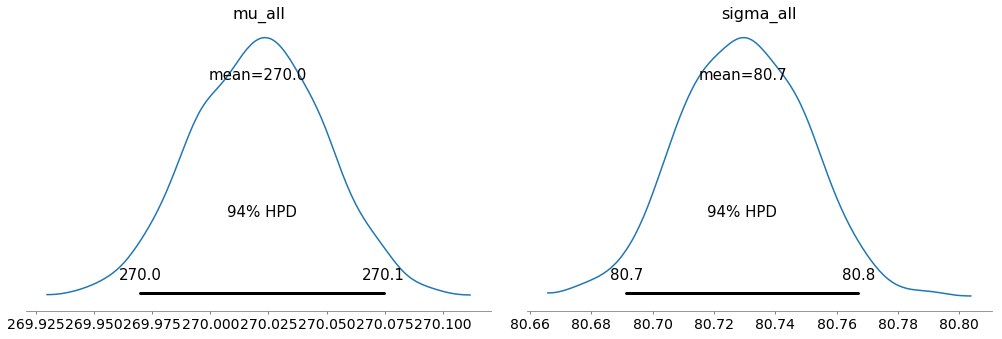

In [46]:
az.plot_posterior(traz_fe_b_gr, var_names=['mu_all', 'sigma_all'])
plt.show()

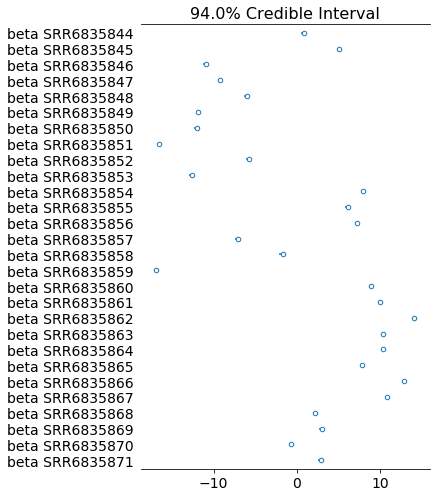

In [48]:
az.plot_forest(traz_fe_b_gr, var_names=['beta'])
plt.show()

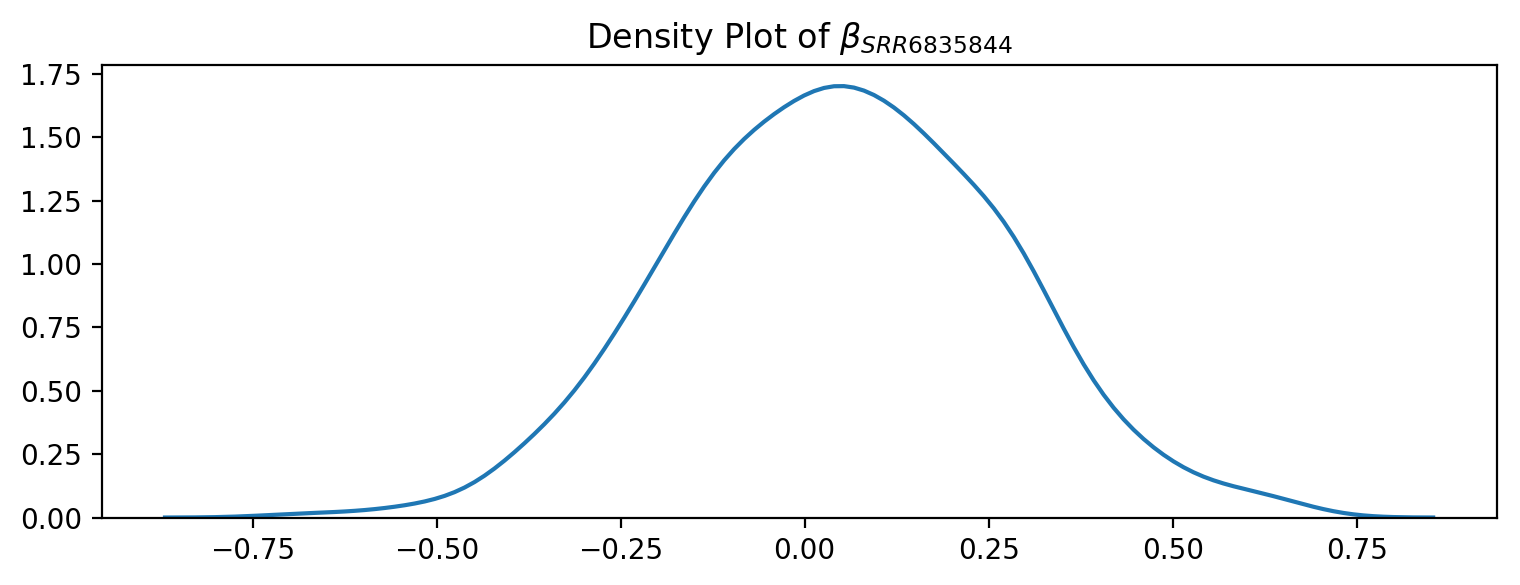

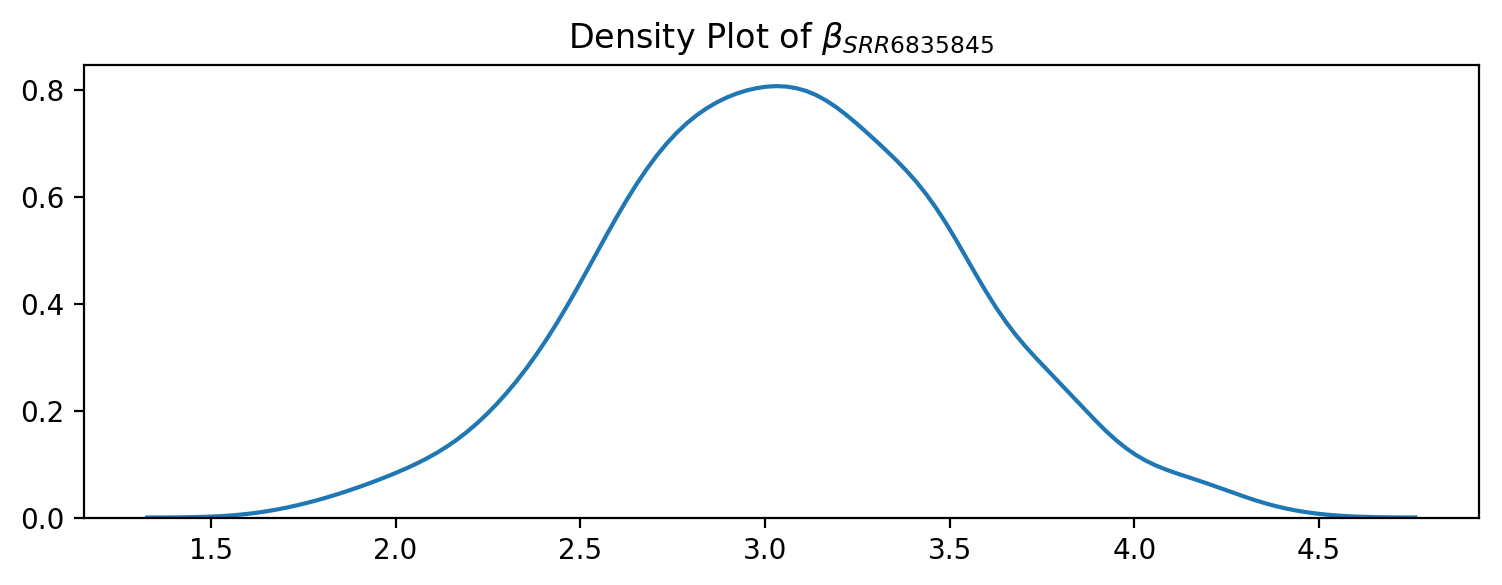

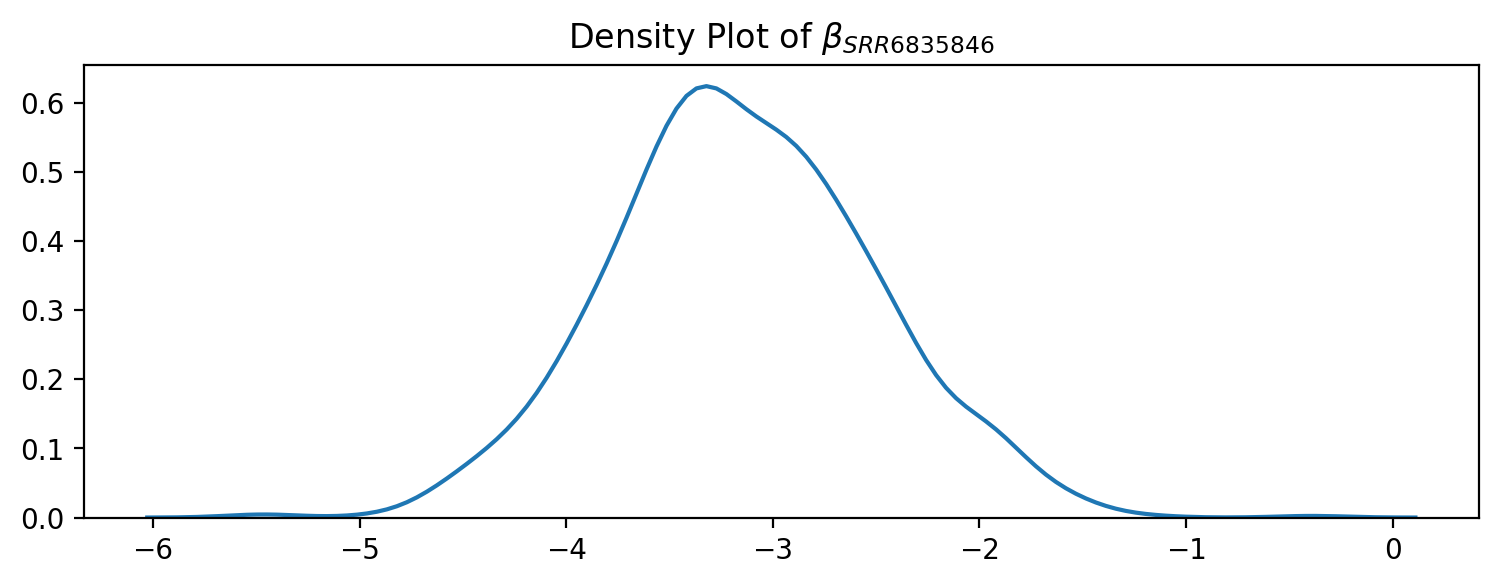

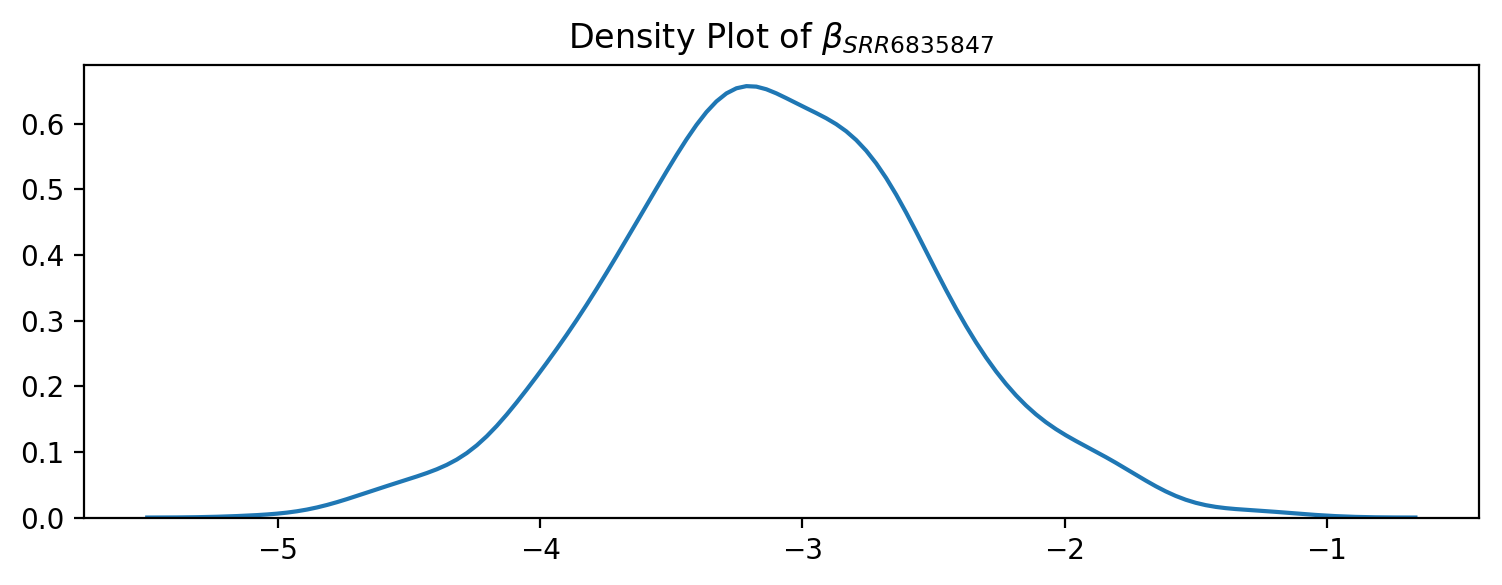

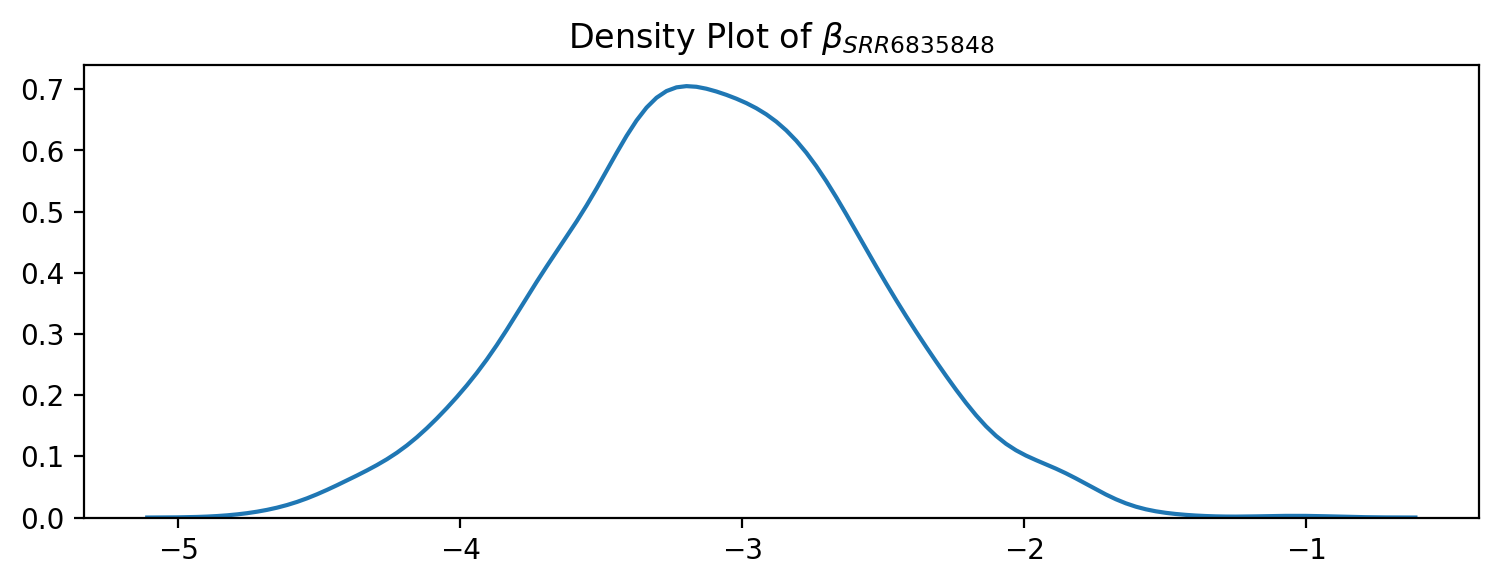

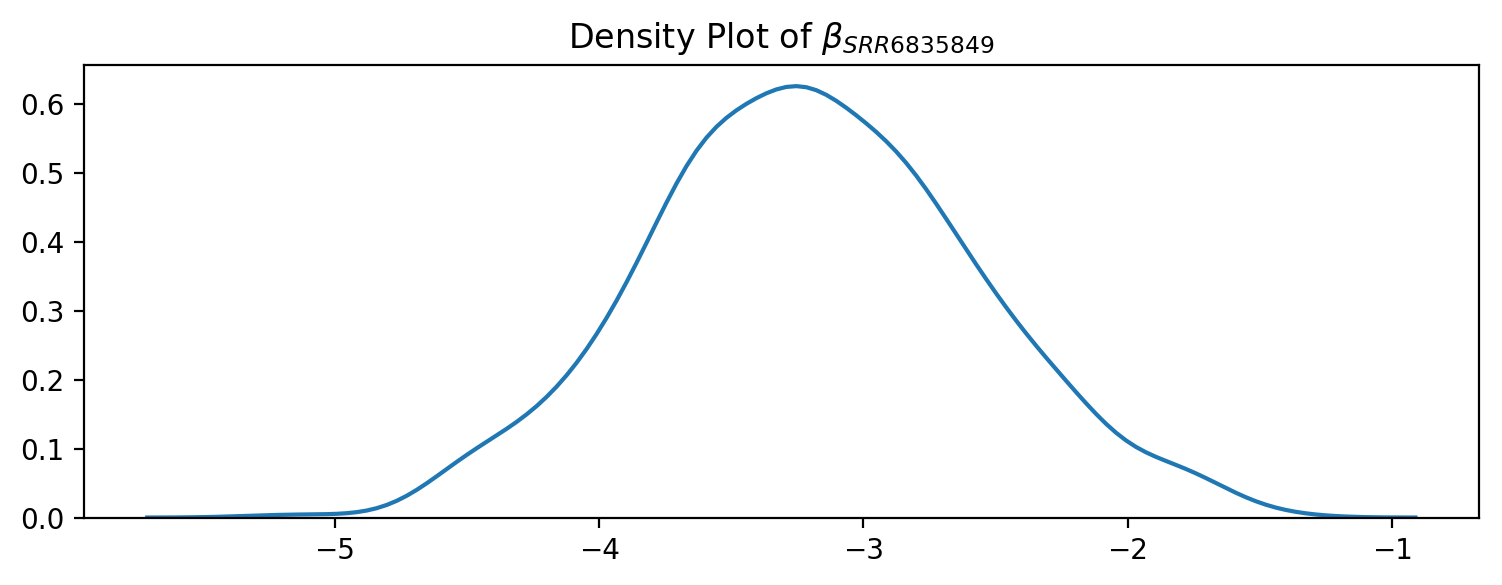

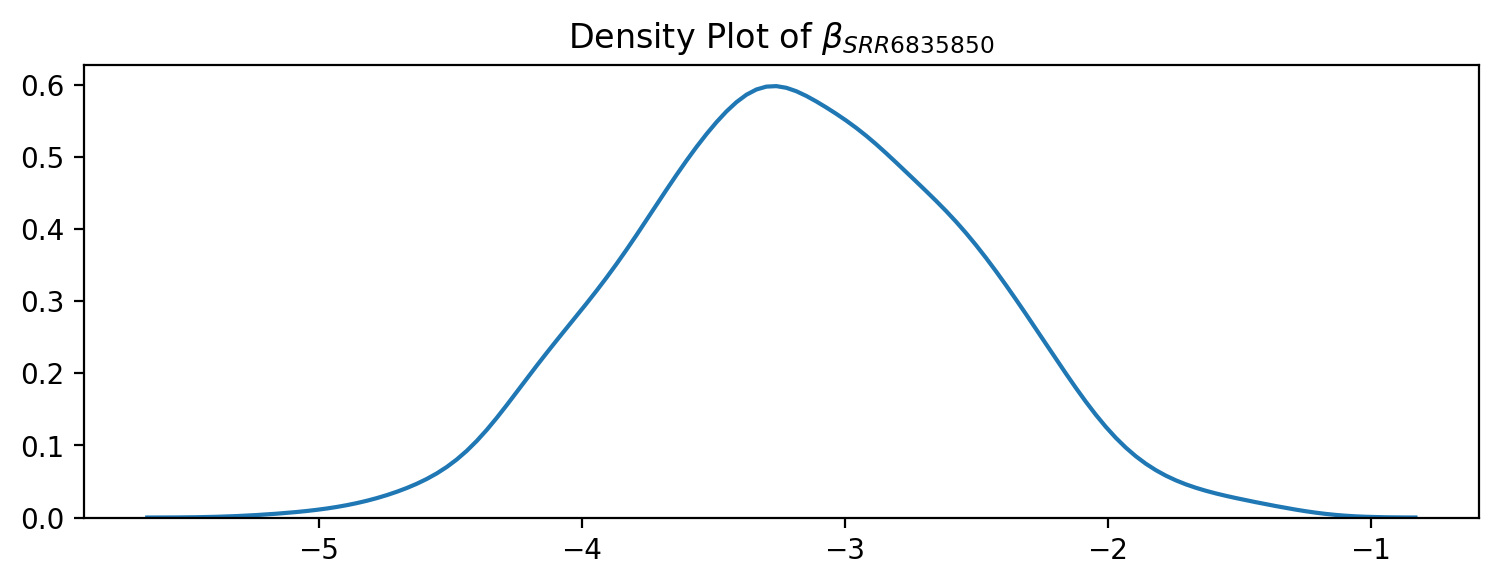

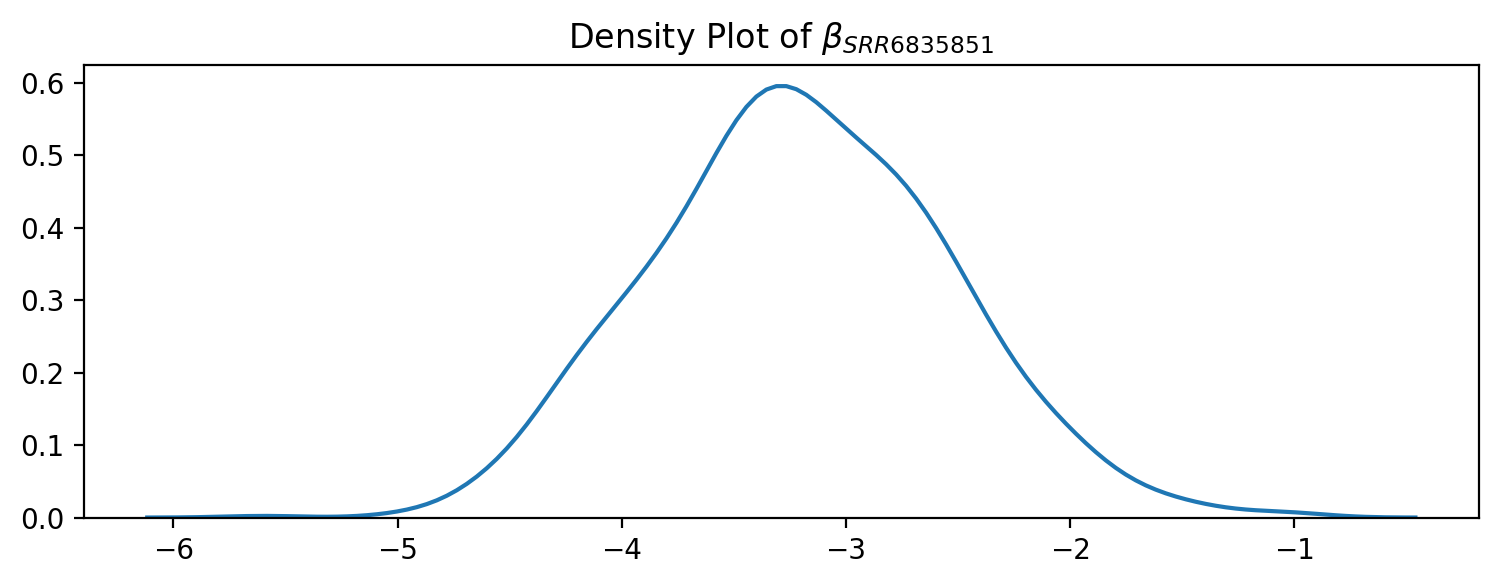

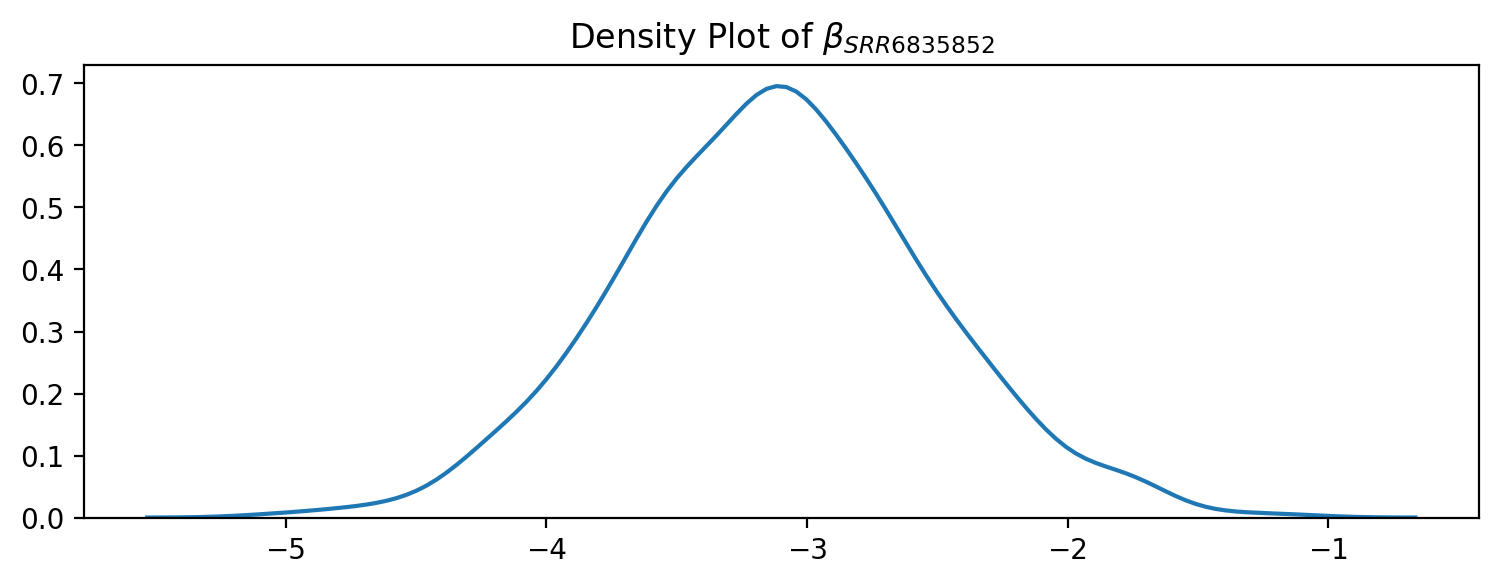

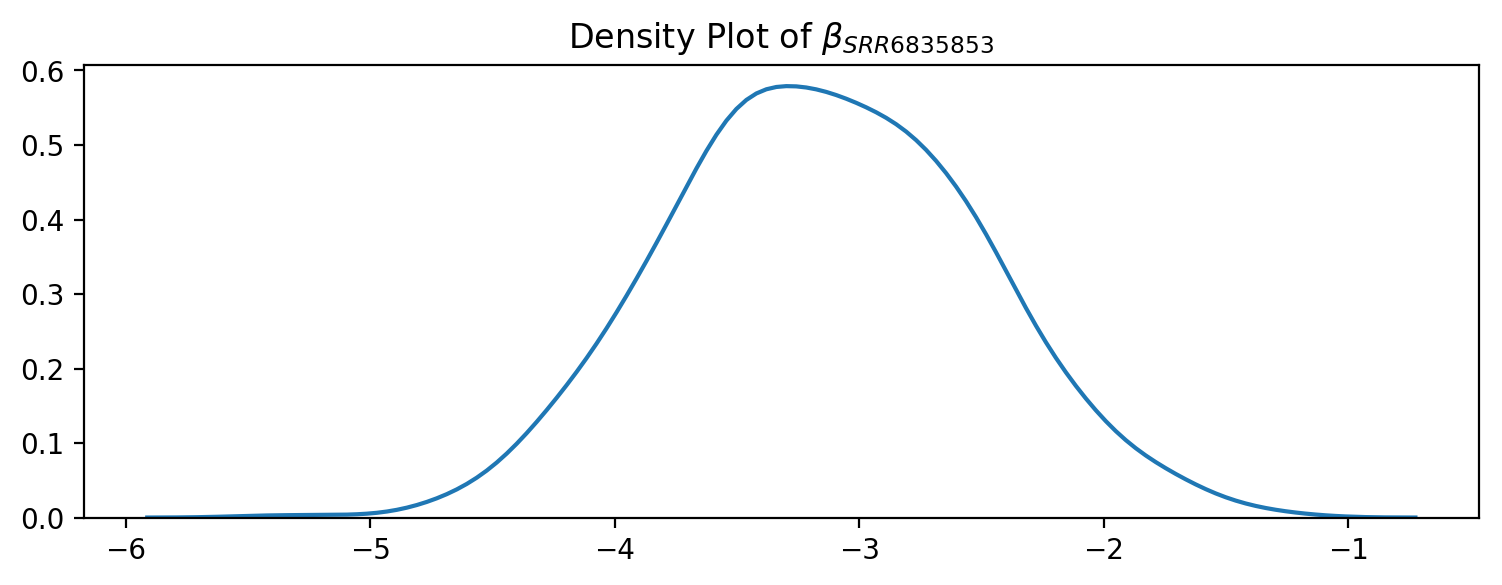

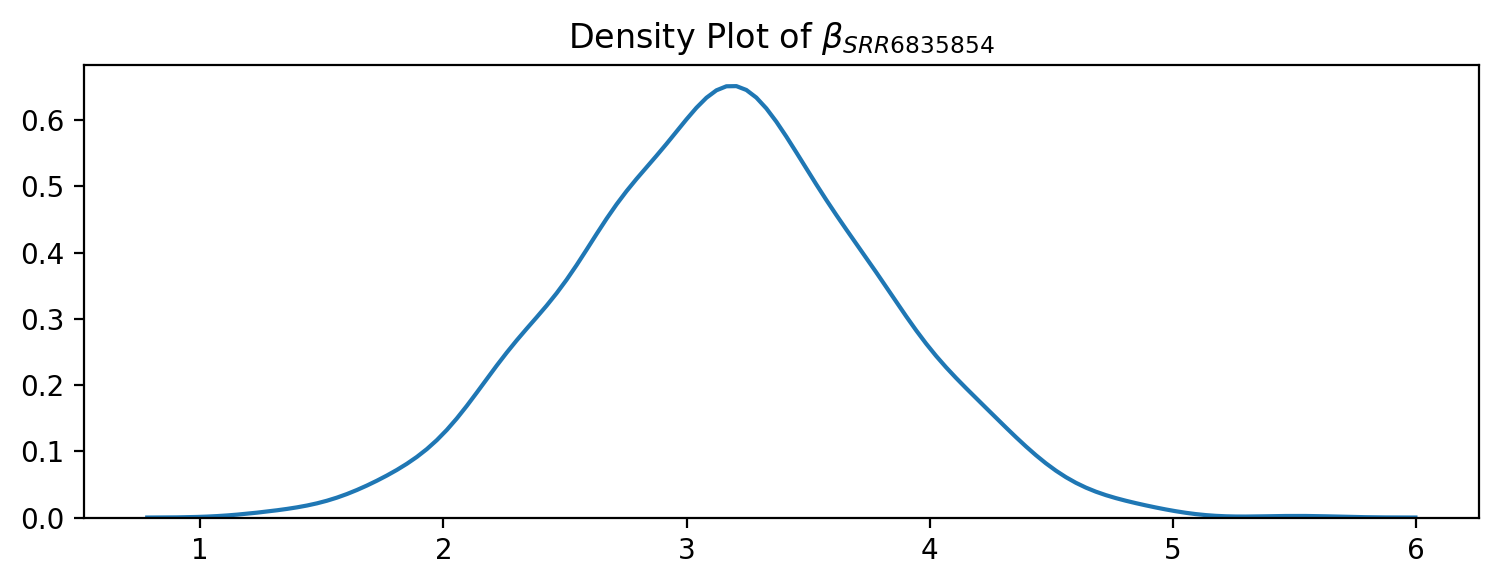

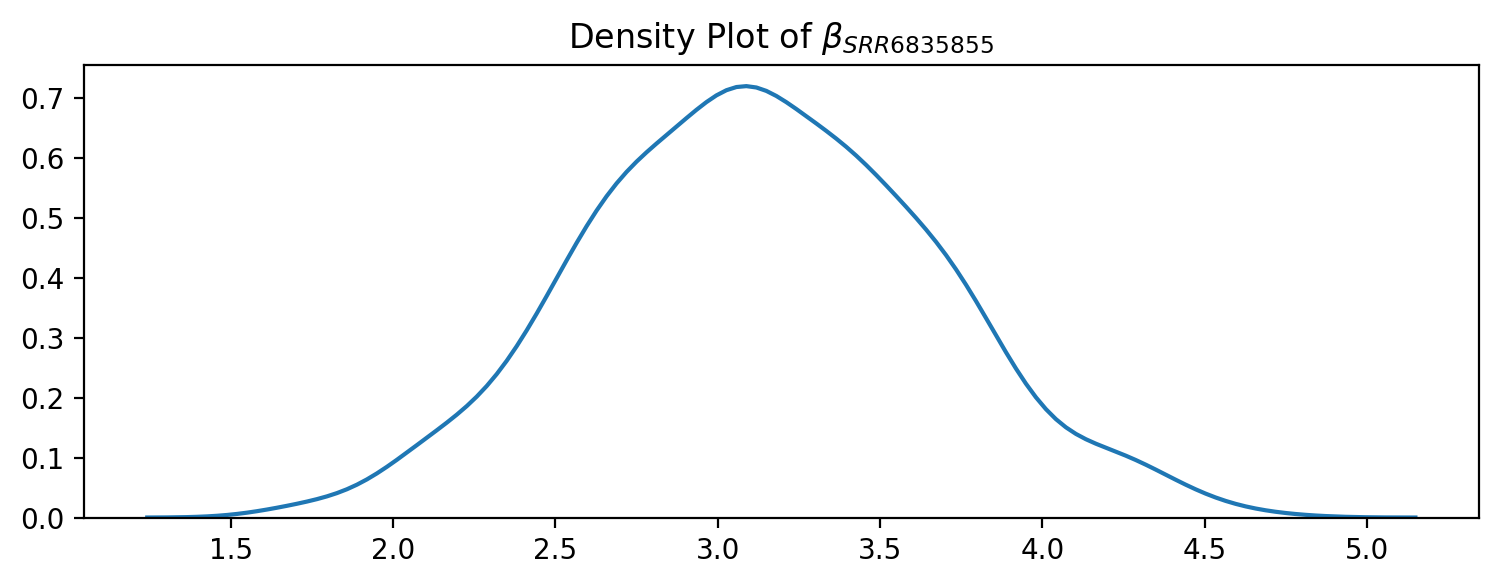

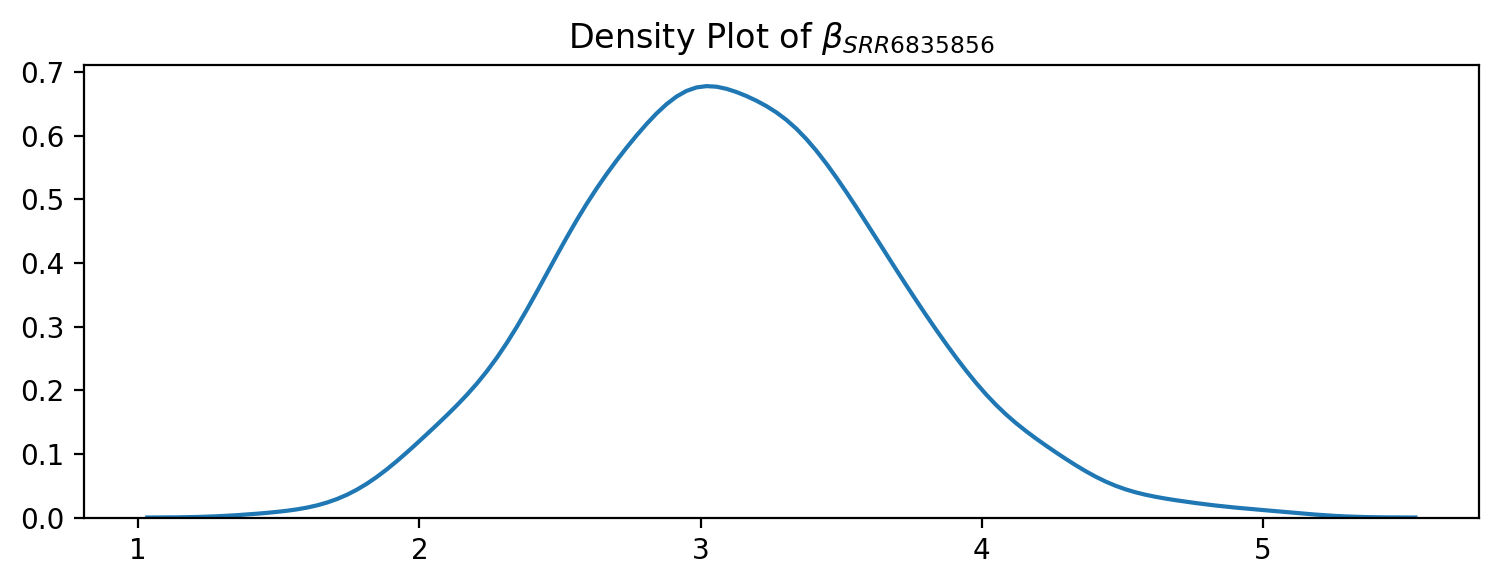

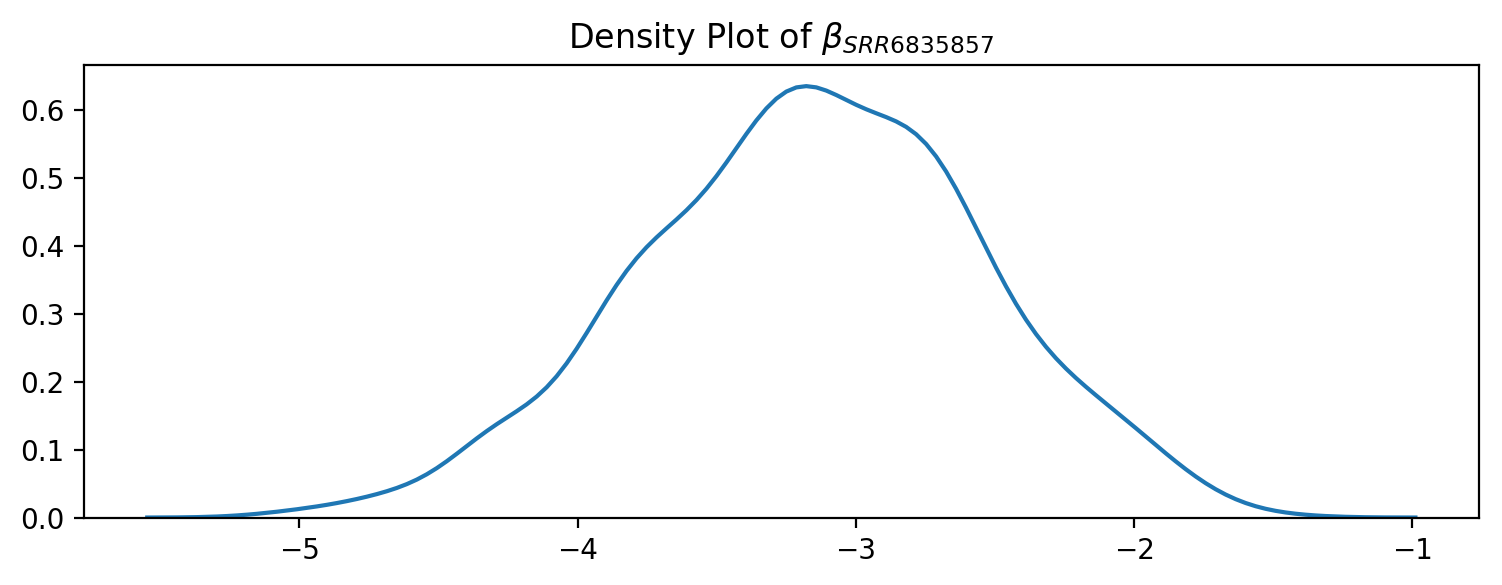

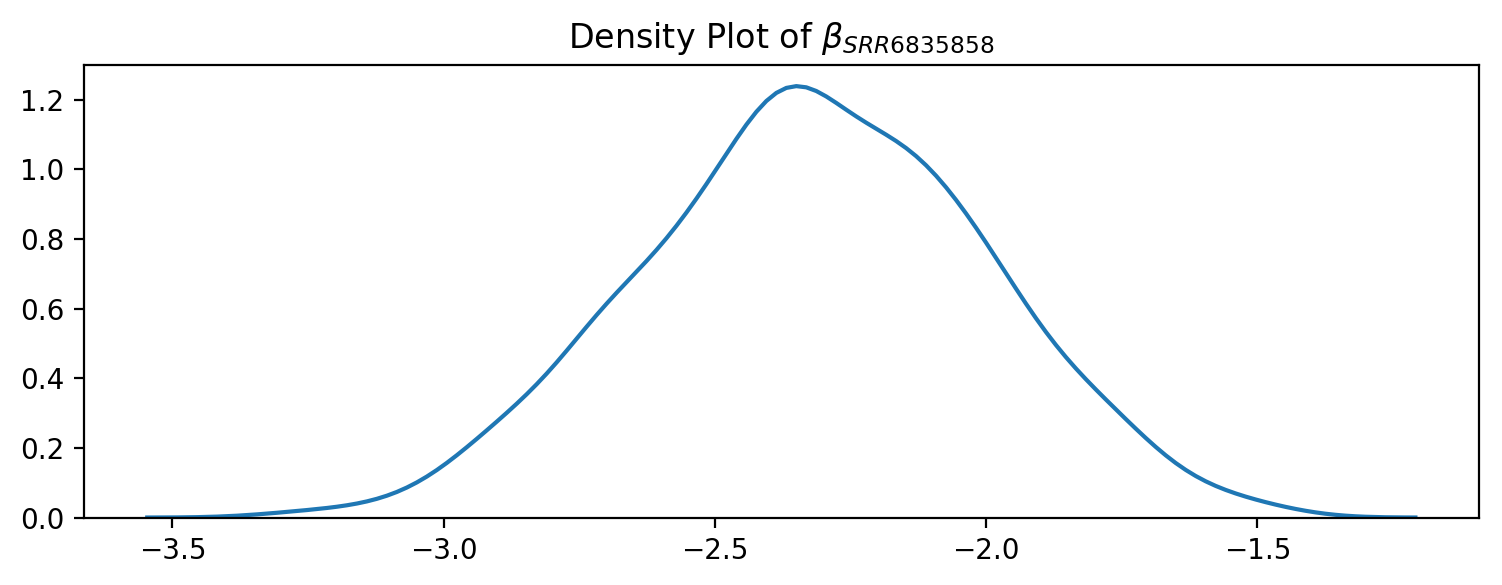

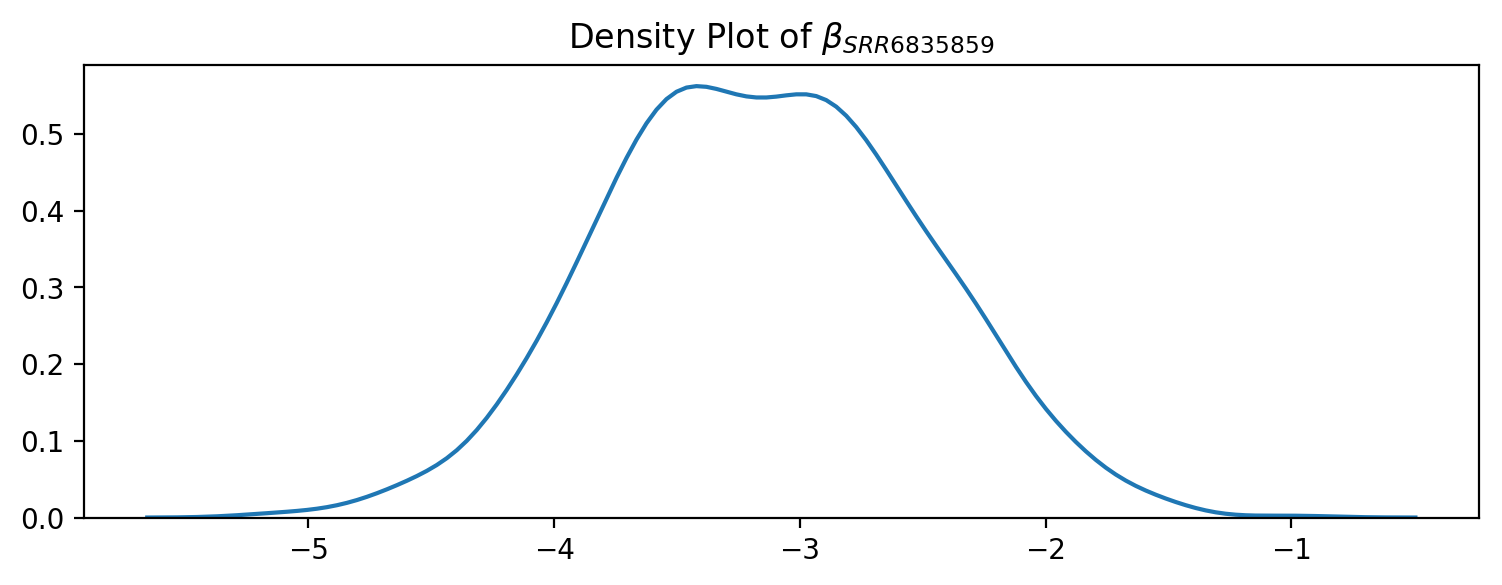

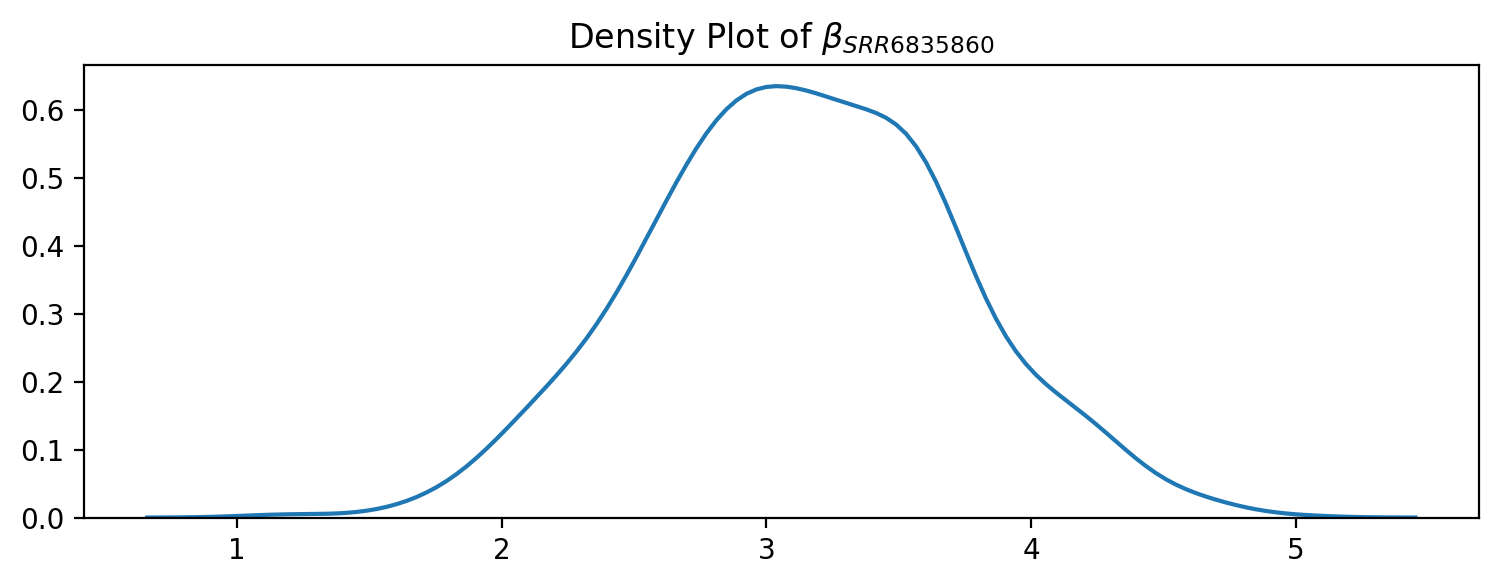

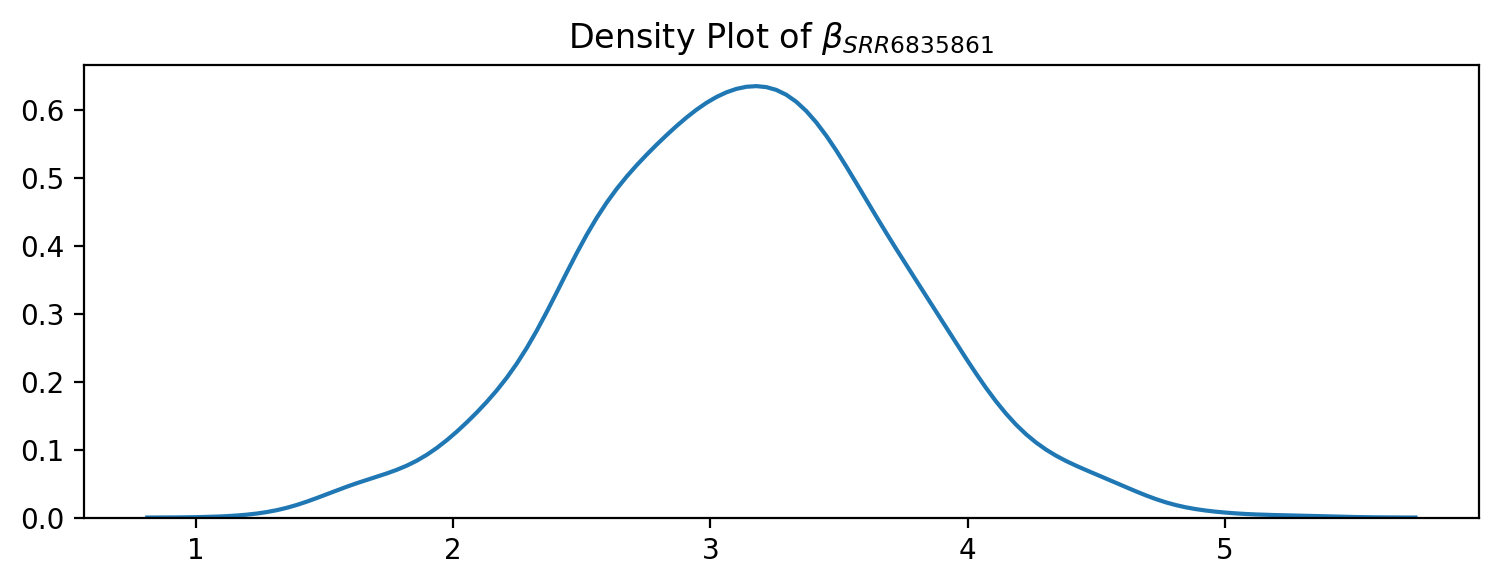

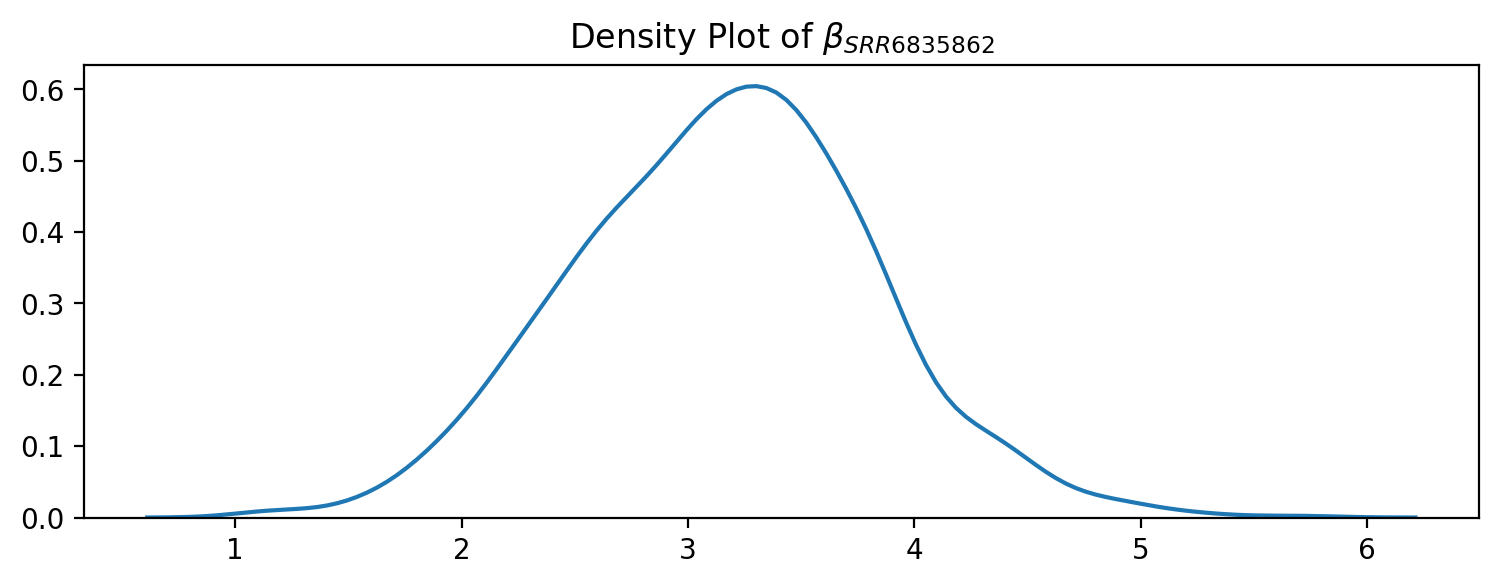

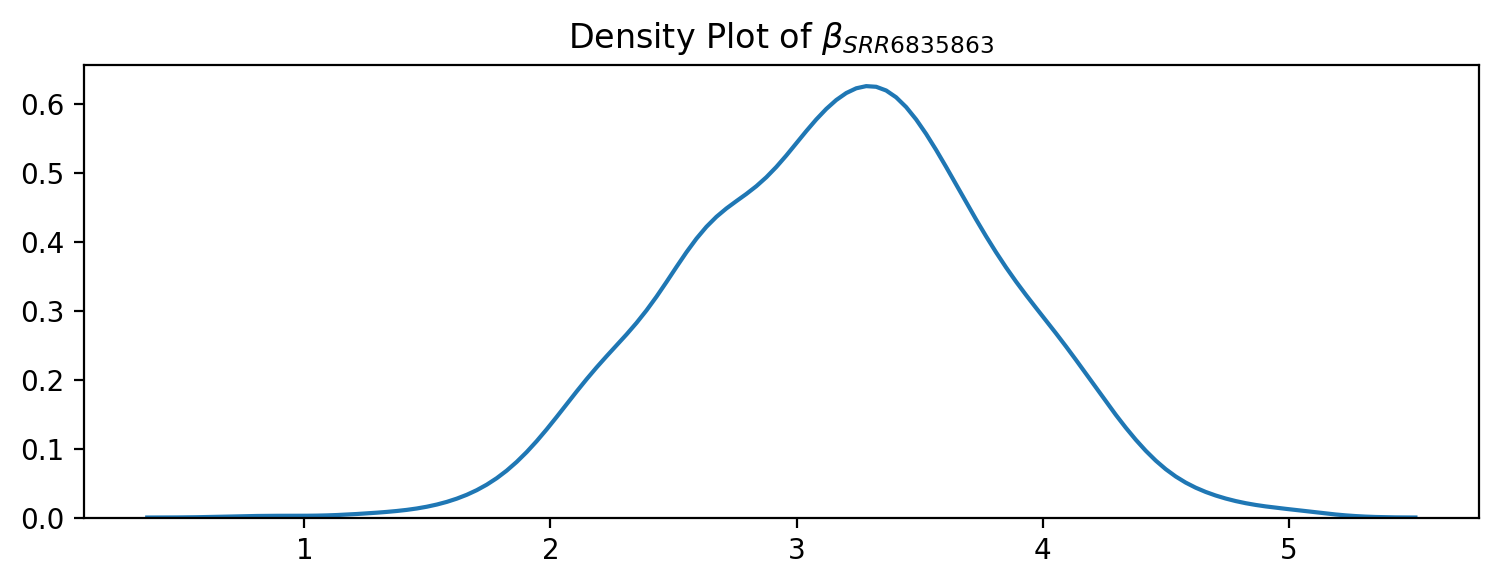

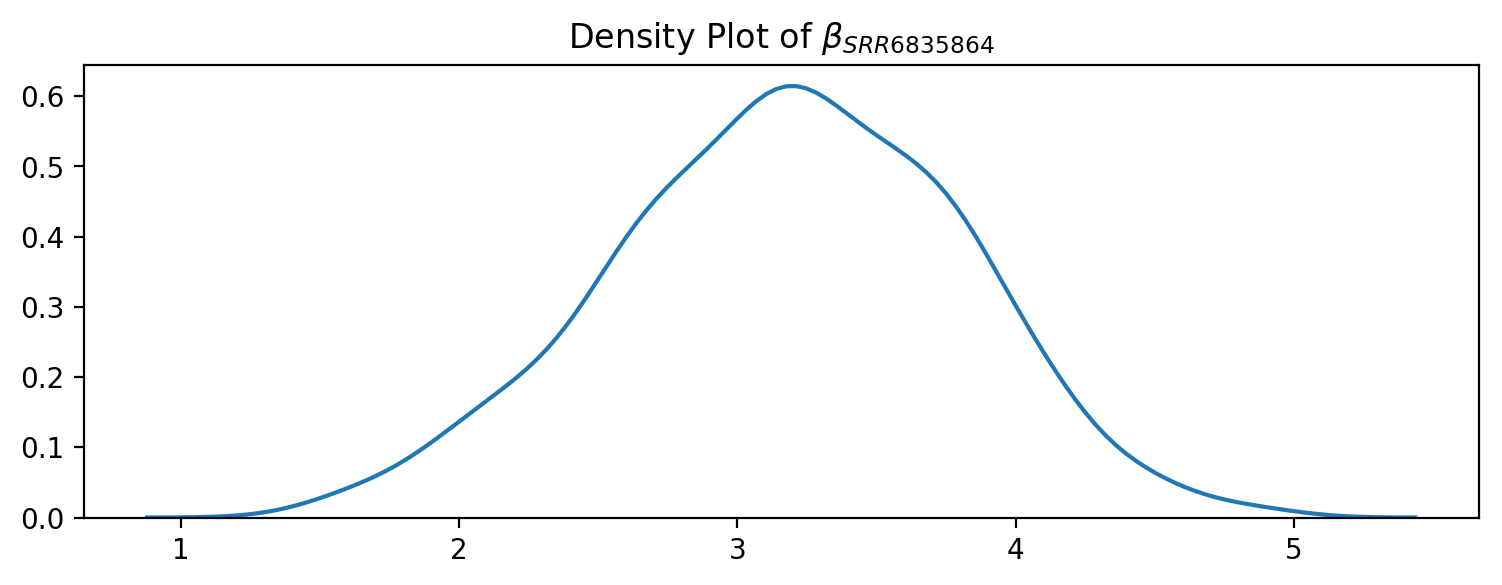

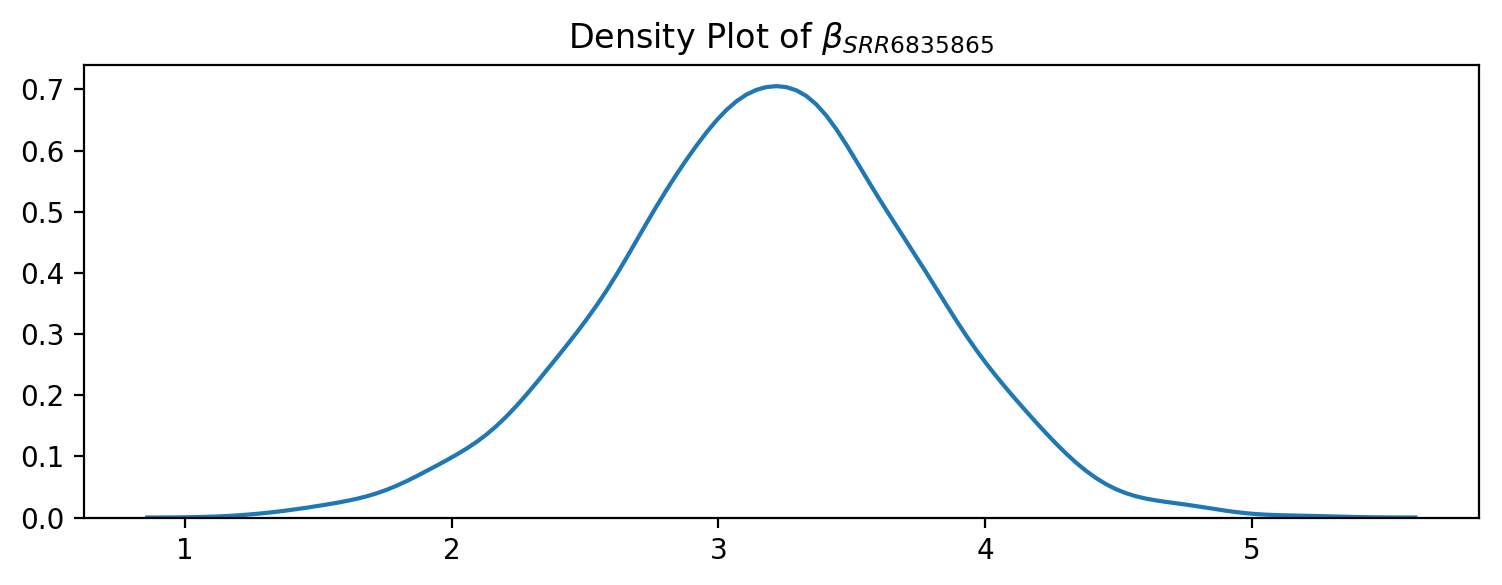

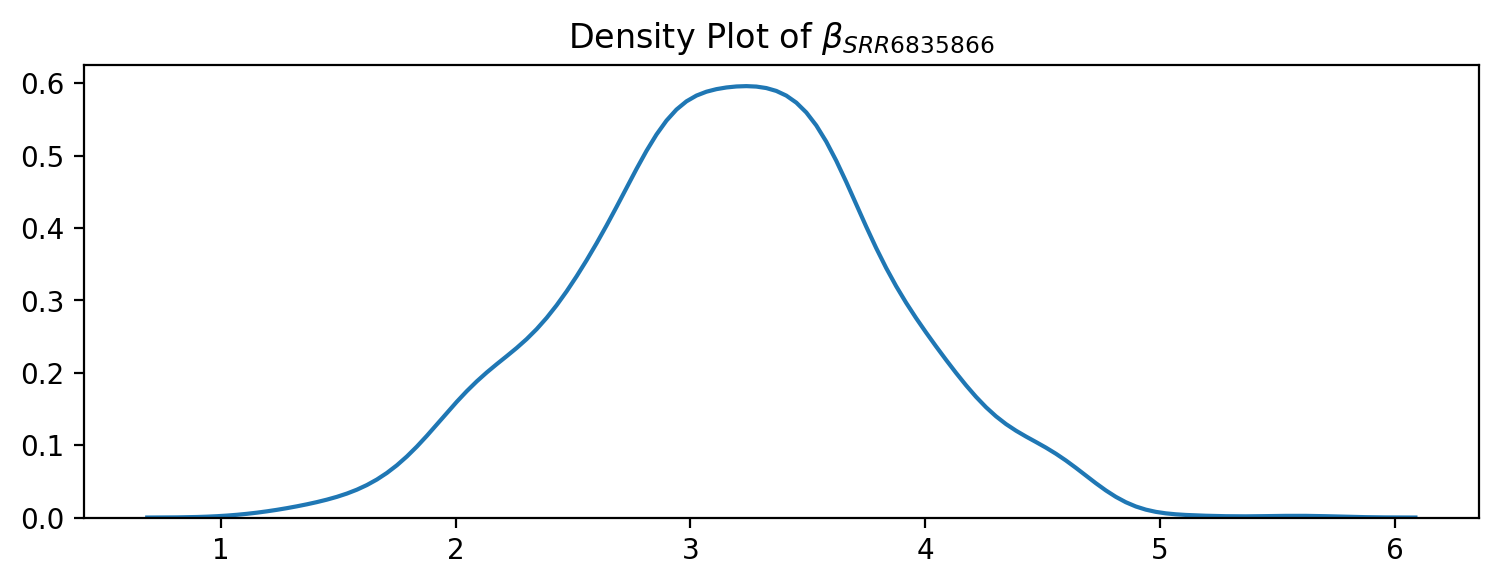

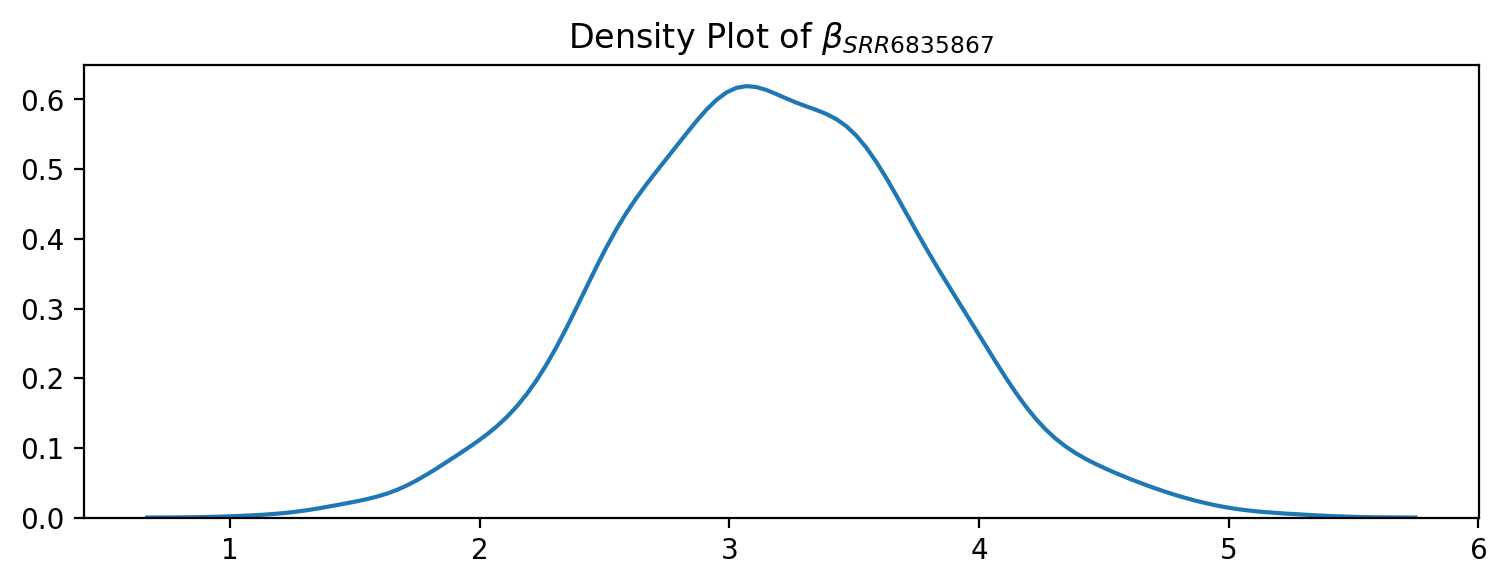

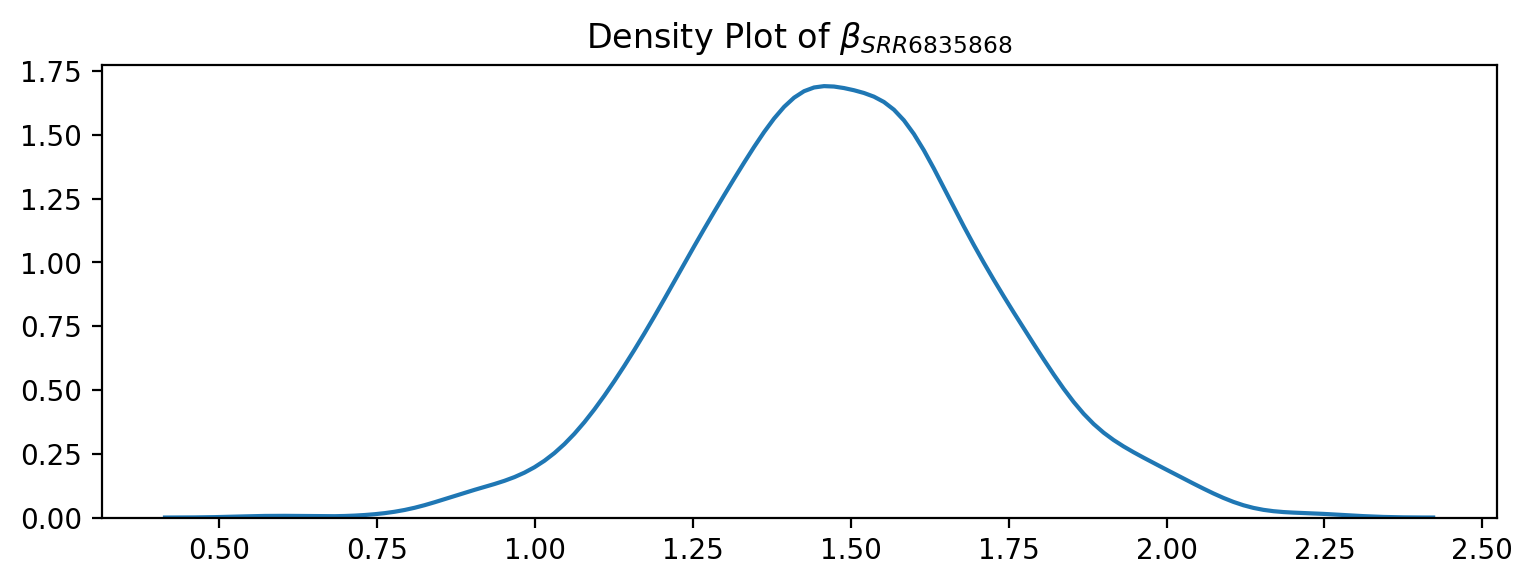

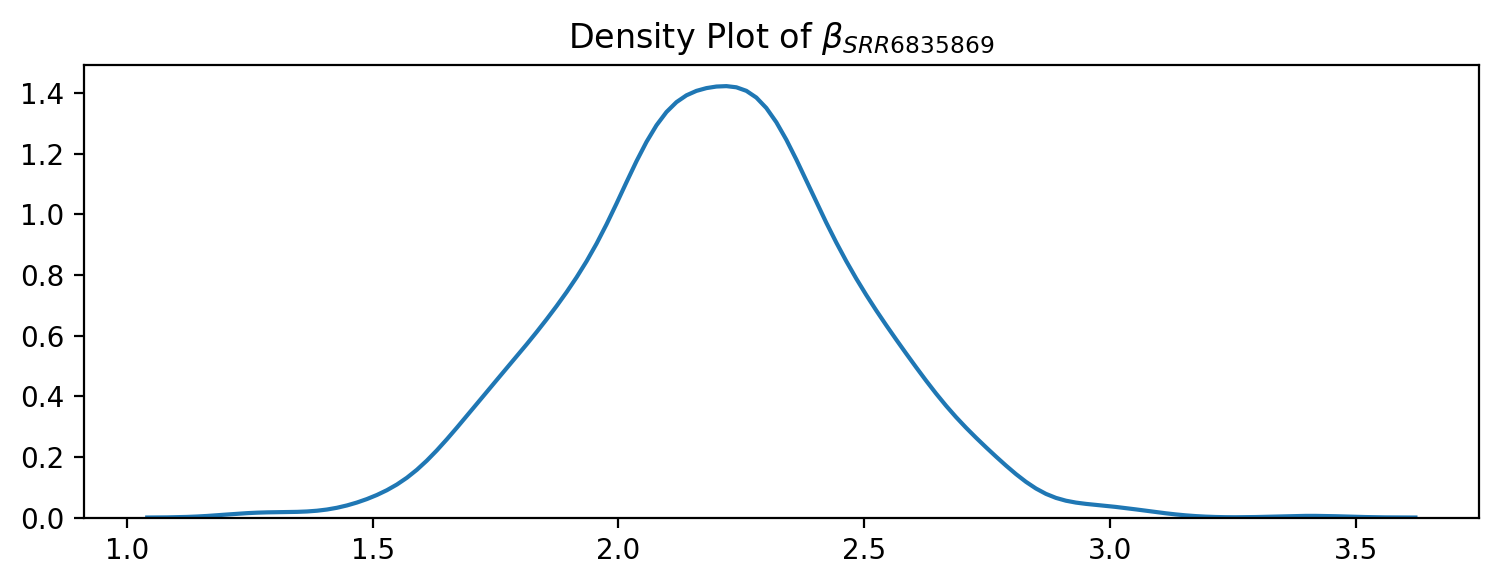

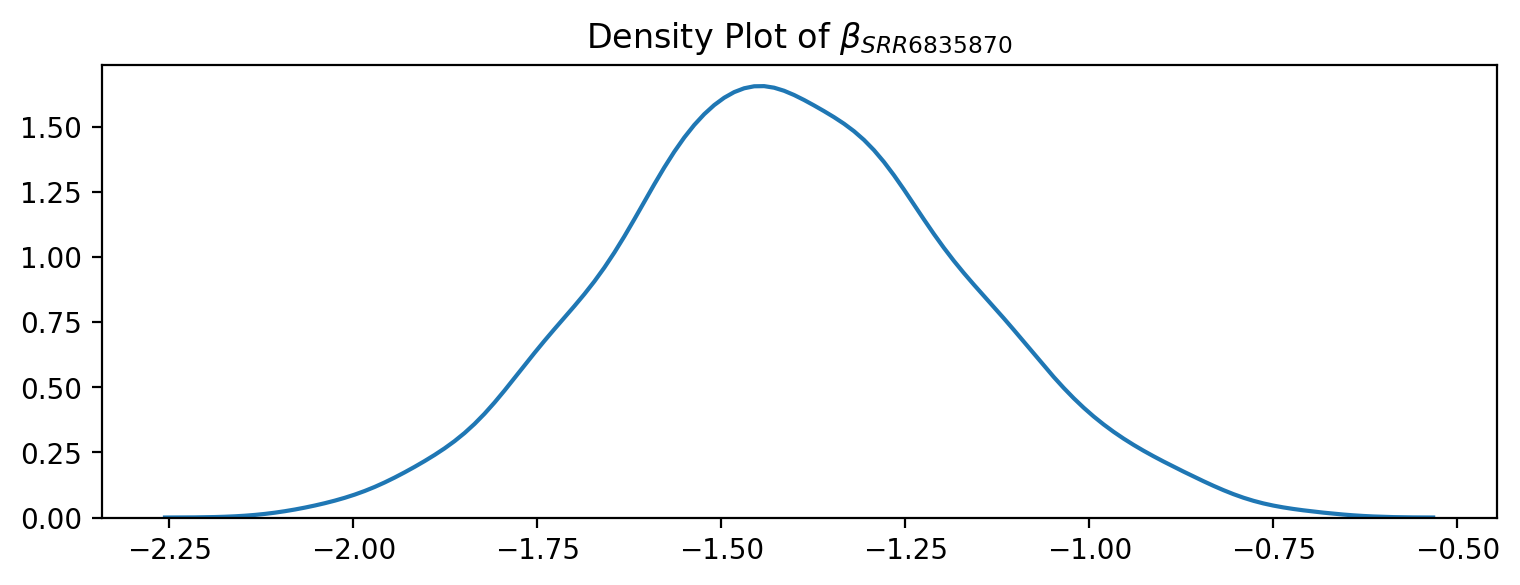

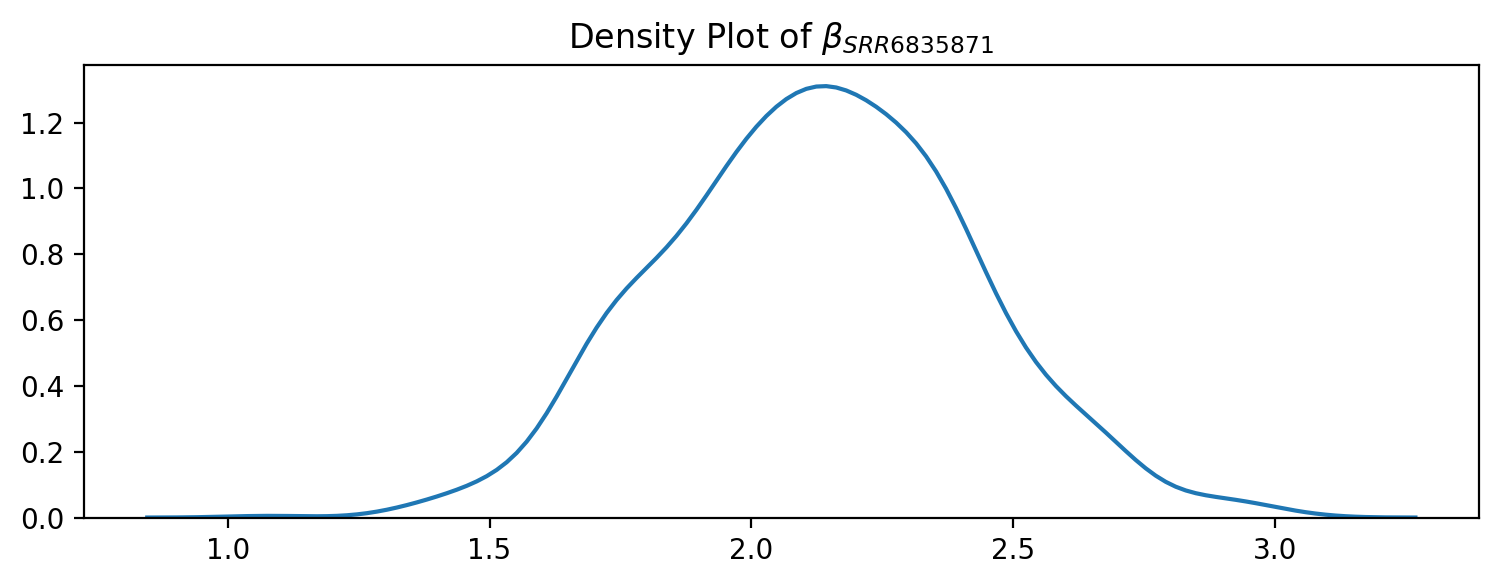

In [15]:
for i, b in enumerate(batch_coords):
    plt.figure(figsize=(9,3), dpi=200)
    sns.kdeplot(sample_fe_b_gr['beta'][:,i])
    plt.title(r"Density Plot of $\beta_{{{}}}$".format(b))
    plt.show()

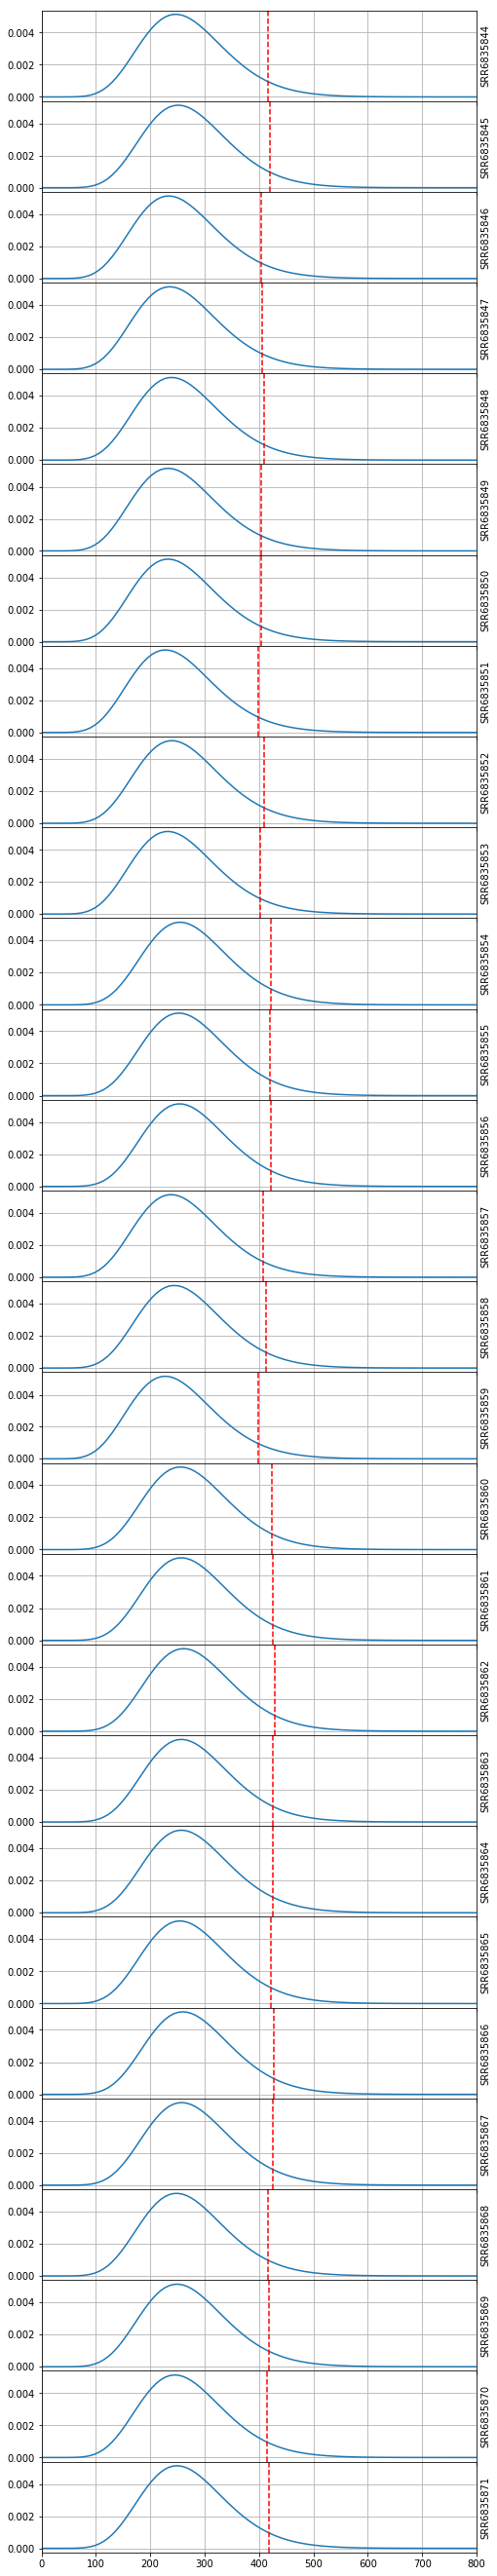

In [66]:
X_plt = np.linspace(1, 800, num=100)
mu_all_hat = np.mean(sample_fe_b_gr['mu_all'])
sigma_all_hat = np.mean(sample_fe_b_gr['sigma_all'])
beta_hat = np.mean(sample_fe_b_gr['beta'], axis=0)

f, axs = plt.subplots(B, sharex=True, figsize=(8,48))
f.subplots_adjust(hspace=0)
axs[0].set_xlim(left=0, right=800)

for i in range(B):
    a, scale = gamma_reparam(mu_all_hat + beta_hat[i], sigma_all_hat)
    Y_plt = stats.gamma(a=a, scale=scale).pdf(x=X_plt)
    axs[i].plot(X_plt, Y_plt)
    axs[i].grid(True)
    axs[i].set(ylabel=batch_agg_coords[i])
    axs[i].yaxis.set_label_position("right")
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
plt.show()

## Aggregated Genes

In [70]:
with pm.Model() as fixed_effects_gene_gamma_regression:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=G)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    
    # regression functions
    mu = mu_all + pm.math.dot(X_agg_g, beta)
    
    y = pm.Potential('y_logp_weighted', W_agg_g*pm.Gamma.dist(mu=mu, sd=sigma_all).logp(Y_agg_g))
    
    vi_fe_g_gr = pm.ADVI()
    
fit_fe_g_gr = vi_fe_g_gr.fit(n=100000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 4.8861e+07: 100%|██████████| 100000/100000 [13:50<00:00, 120.35it/s]
Finished [100%]: Average Loss = 4.8861e+07


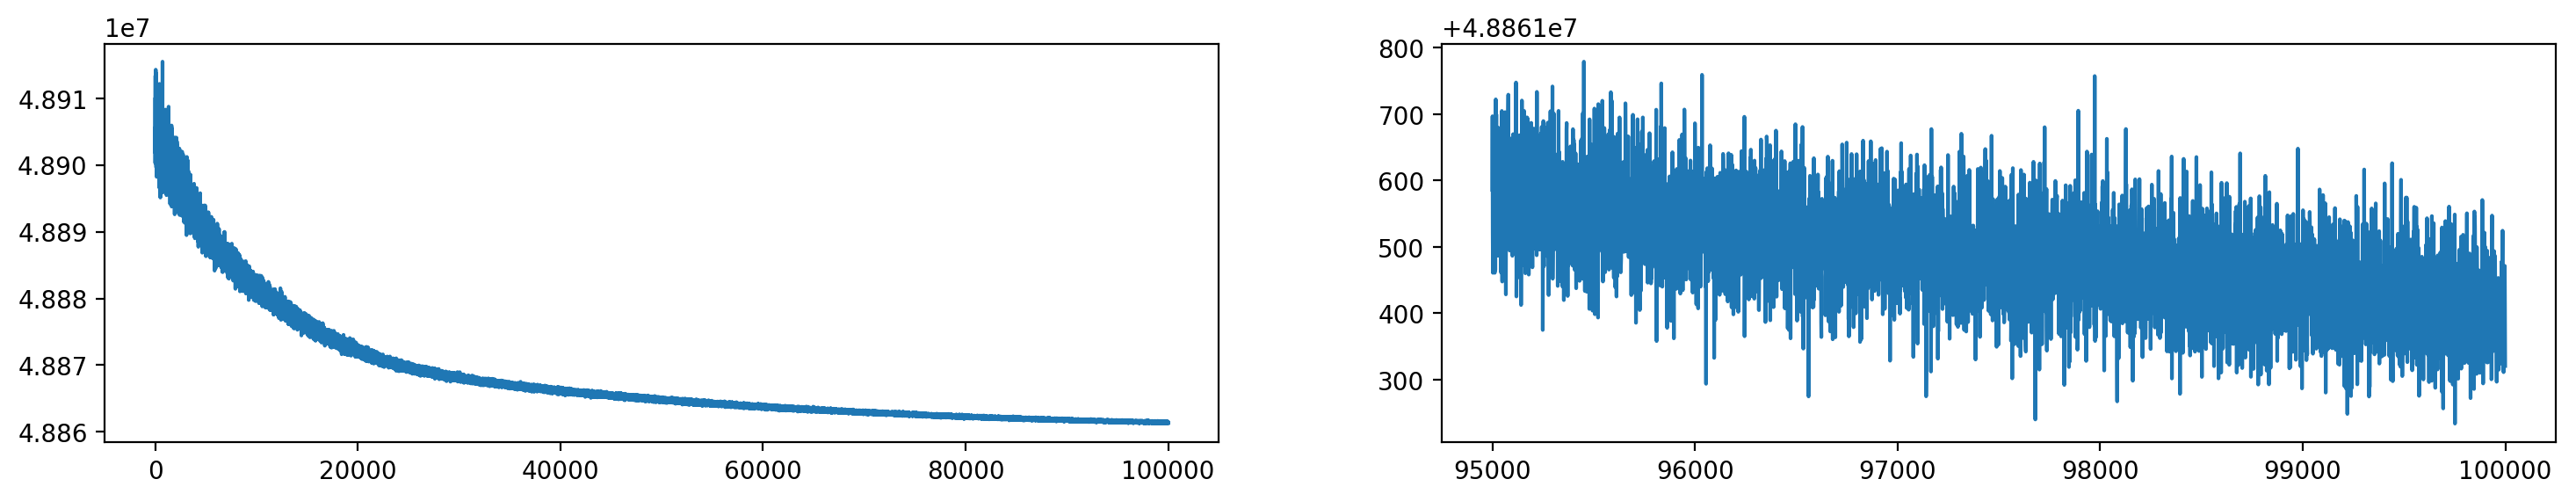

In [71]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_fe_g_gr.hist)

plt.subplot(1,2,2)
plt.plot(np.arange(95000,100000), fit_fe_g_gr.hist[95000:])
plt.show()

Well, this one appears further from convergence, so we need to continue optimizing.

In [72]:
fit_fe_g_gr2 = vi_fe_g_gr.fit(n=100000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 4.886e+07: 100%|██████████| 100000/100000 [09:38<00:00, 172.72it/s]
Finished [100%]: Average Loss = 4.886e+07


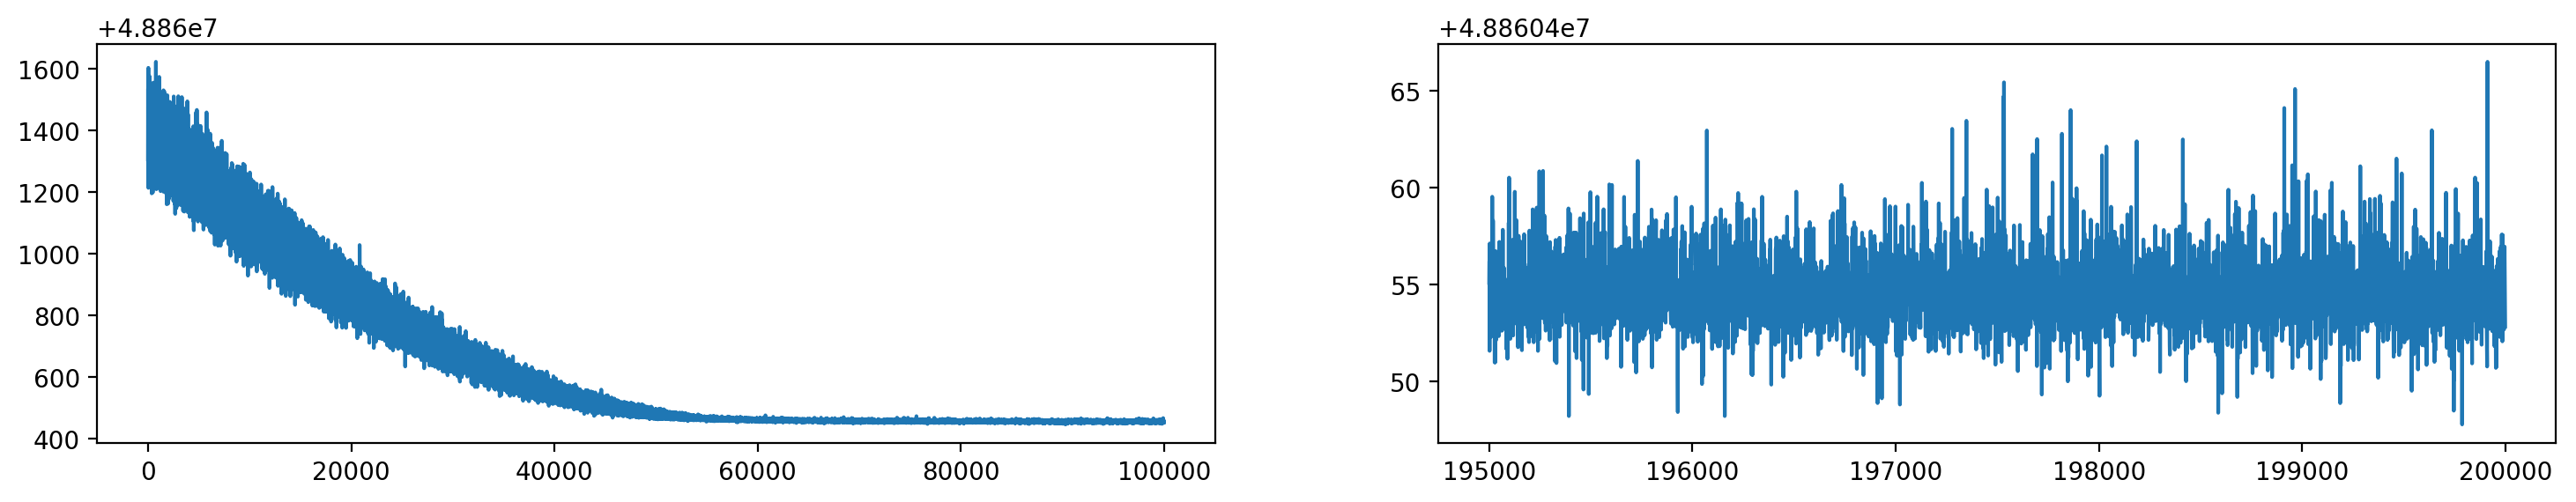

In [75]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_fe_g_gr2.hist[100000:])

plt.subplot(1,2,2)
plt.plot(np.arange(195000,200000), fit_fe_g_gr2.hist[195000:])
plt.show()

Okay, now it appears converged.

In [76]:
sample_fe_g_gr = fit_fe_g_gr.sample(2000)
pm.summary(sample_fe_g_gr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_all,272.784369,0.028781,0.000621,272.728609,272.840929
beta__0,3.453209,0.386048,0.008376,2.708409,4.227138
beta__1,-10.692598,0.108144,0.002484,-10.904455,-10.489841
beta__2,0.498813,0.355011,0.007499,-0.178138,1.184561
beta__3,3.828359,0.373978,0.008524,3.089714,4.539756
beta__4,-3.965887,0.218029,0.004813,-4.356298,-3.508916
beta__5,-3.566125,0.383603,0.008559,-4.290396,-2.815801
beta__6,-4.706495,0.112928,0.002735,-4.920972,-4.484967
beta__7,1.125466,0.715403,0.016007,-0.301713,2.411826
beta__8,1.442954,0.144206,0.003344,1.162639,1.735341


In [77]:
traz_fe_g_gr = az.from_pymc3(trace=sample_fe_g_gr,
                             coords={'gene': gene_agg_coords},
                             dims={'beta': ['gene']})

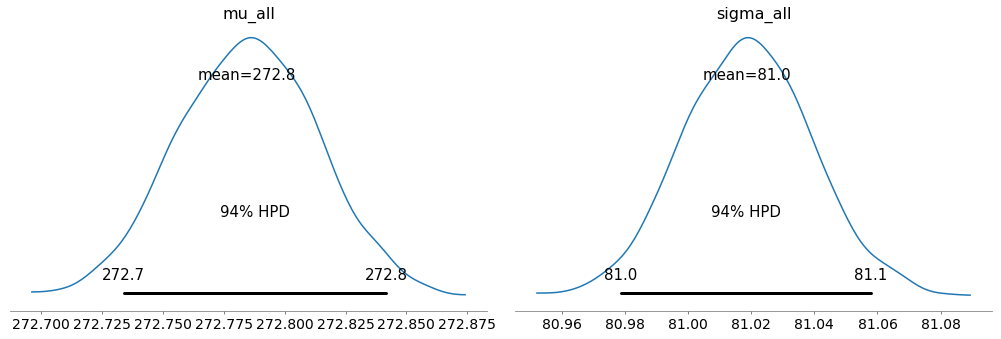

In [78]:
az.plot_posterior(traz_fe_g_gr, var_names=['mu_all', 'sigma_all'])
plt.show()

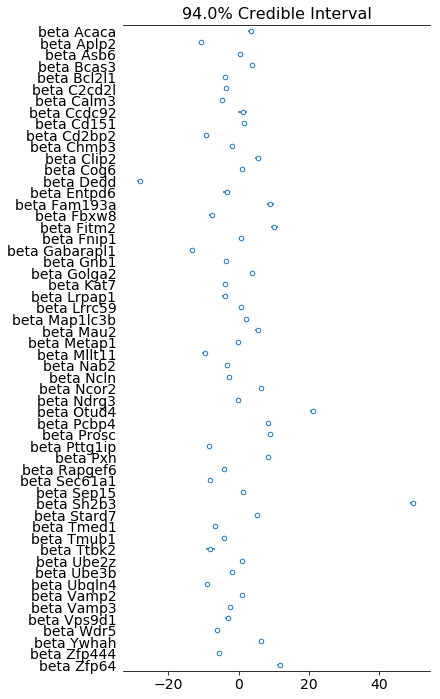

In [79]:
az.plot_forest(traz_fe_g_gr, var_names=['beta'])
plt.show()

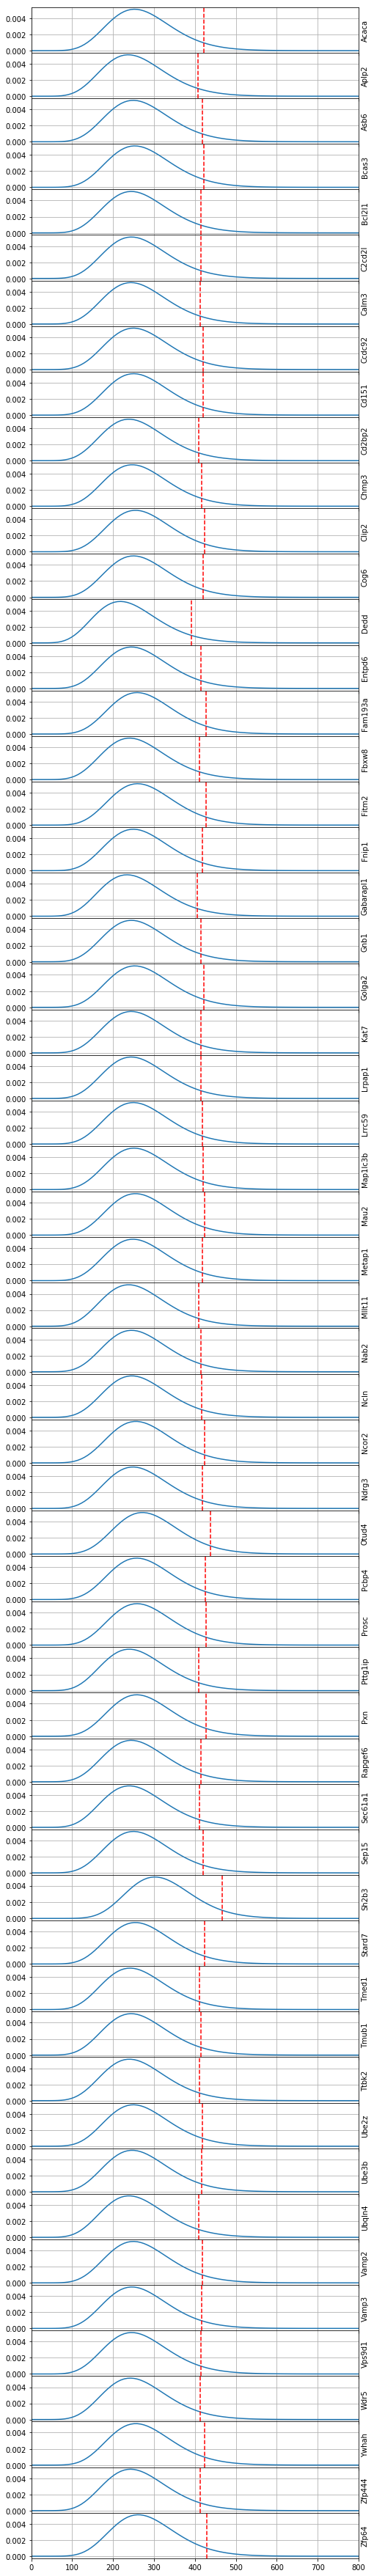

In [81]:
X_plt = np.linspace(1, 800, num=100)
mu_all_hat = np.mean(sample_fe_g_gr['mu_all'])
sigma_all_hat = np.mean(sample_fe_g_gr['sigma_all'])
beta_hat = np.mean(sample_fe_g_gr['beta'], axis=0)

f, axs = plt.subplots(G, sharex=True, figsize=(8,64))
f.subplots_adjust(hspace=0)
axs[0].set_xlim(left=0, right=800)

for i in range(G):
    a, scale = gamma_reparam(mu_all_hat + beta_hat[i], sigma_all_hat)
    Y_plt = stats.gamma(a=a, scale=scale).pdf(x=X_plt)
    axs[i].plot(X_plt, Y_plt)
    axs[i].grid(True)
    axs[i].set(ylabel=gene_agg_coords[i])
    axs[i].yaxis.set_label_position("right")
    
    axs[i].axvline(x=stats.gamma(a=a, scale=scale).isf(0.05), color='r', linestyle='--')
    
plt.show()

## Full Model

In [93]:
X_mb = pm.Minibatch(X, batch_size=10000, random_seed=42)
W_mb = pm.Minibatch(W, batch_size=10000, random_seed=42)
Y_mb = pm.Minibatch(Y, batch_size=10000, random_seed=42)
tot_size = len(Y)

/Users/mfansler/miniconda3/envs/pymc36/lib/python3.7/site-packages/pymc3/data.py:244: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


In [95]:
with pm.Model() as fixed_effects_full_gamma_regression:
    # mu prior, and coefficients
    mu_all = pm.Normal('mu_all', mu=270, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=B+G)

    # sigma prior, and coefficients
    sigma_all = pm.Normal('sigma_all', mu=80, sd=5)
    
    # regression functions
    mu = mu_all + pm.math.dot(X_mb, beta)
    
    y = pm.Potential('y_logp_weighted', W_mb*pm.Gamma.dist(mu=mu, sd=sigma_all).logp(Y_mb))
    
    vi_fe_gr = pm.FullRankADVI()
    
fit_fe_gr = vi_fe_gr.fit(n=1000000, callbacks=[pm.callbacks.CheckParametersConvergence()])

Average Loss = 9.4048e+05: 100%|██████████| 1000000/1000000 [1:40:27<00:00, 165.90it/s]
Finished [100%]: Average Loss = 9.4036e+05


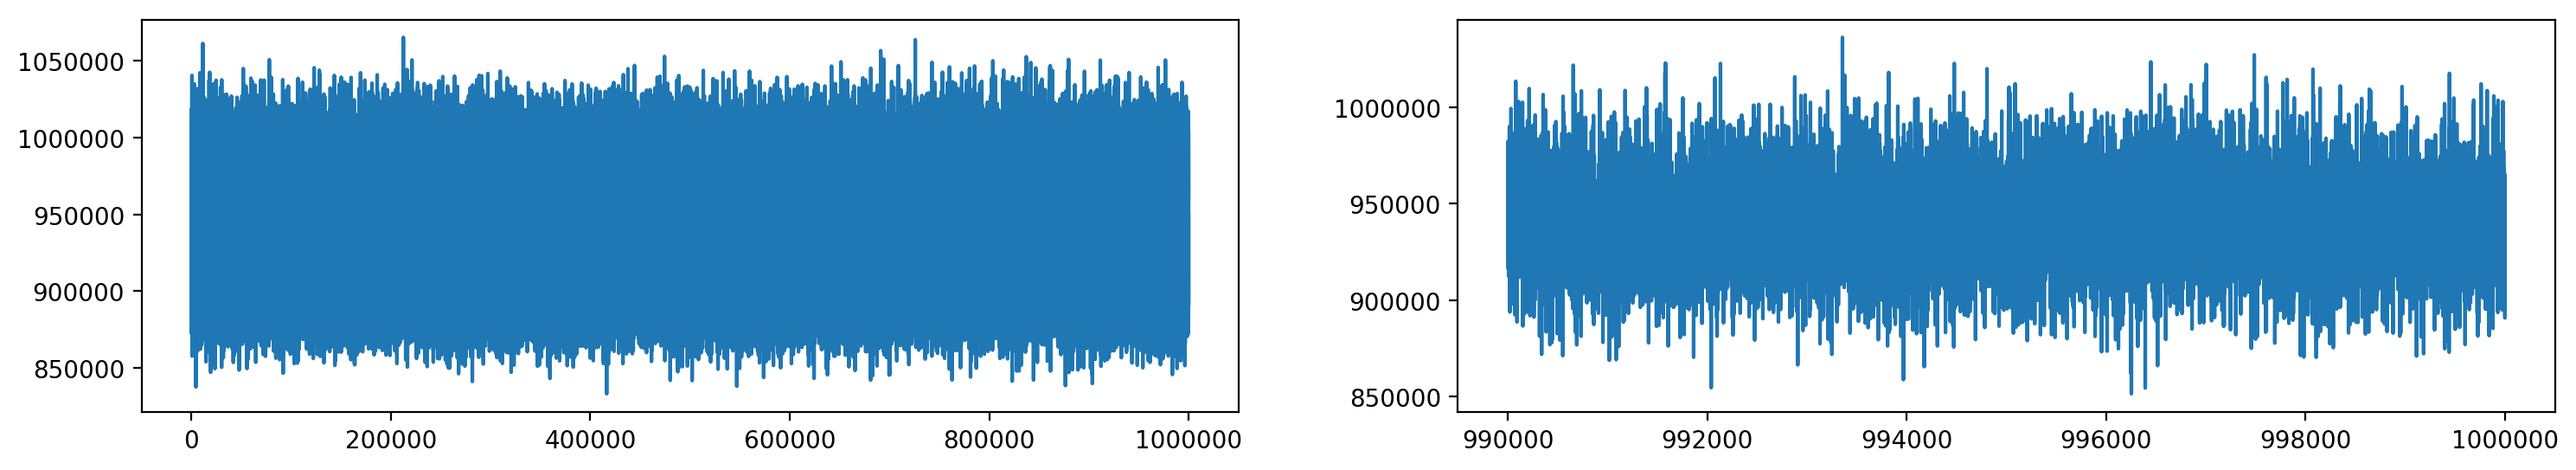

In [97]:
plt.figure(figsize=(18,3), dpi=200)
plt.subplot(1,2,1)
plt.plot(fit_fe_gr.hist)

plt.subplot(1,2,2)
plt.plot(np.arange(990000,1000000), fit_fe_gr.hist[990000:])
plt.show()

In [98]:
sample_fe_gr = fit_fe_gr.sample(2000)
pm.summary(sample_fe_gr)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu_all,271.594703,0.374401,0.008121,270.859669,272.283830
beta__0,0.077561,0.956950,0.020681,-1.882552,1.832734
beta__1,0.087863,0.872676,0.017479,-1.719029,1.677043
beta__2,0.016177,0.952230,0.020563,-1.840418,1.847850
beta__3,0.076533,0.921845,0.017956,-1.693634,1.920961
beta__4,0.105495,0.911450,0.019410,-1.644056,1.846158
beta__5,0.005555,0.964784,0.020976,-1.776713,1.972016
beta__6,0.018588,0.915902,0.019613,-1.714340,1.892537
beta__7,0.015005,1.009987,0.020290,-1.953737,2.096733
beta__8,-0.009618,0.863036,0.021285,-1.754894,1.556492


In [99]:
traz_fe_gr = az.from_pymc3(trace=sample_fe_gr,
                           coords={'batch-gene': batch_coords + gene_coords},
                           dims={'beta': ['batch-gene']})

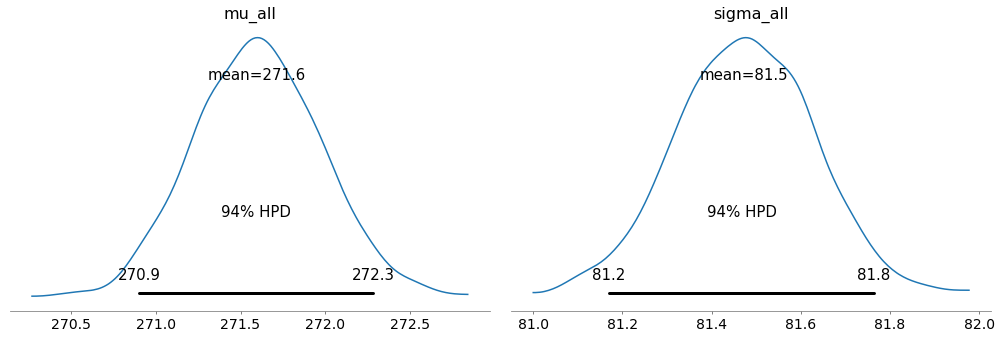

In [100]:
az.plot_posterior(traz_fe_gr, var_names=['mu_all', 'sigma_all'])
plt.show()

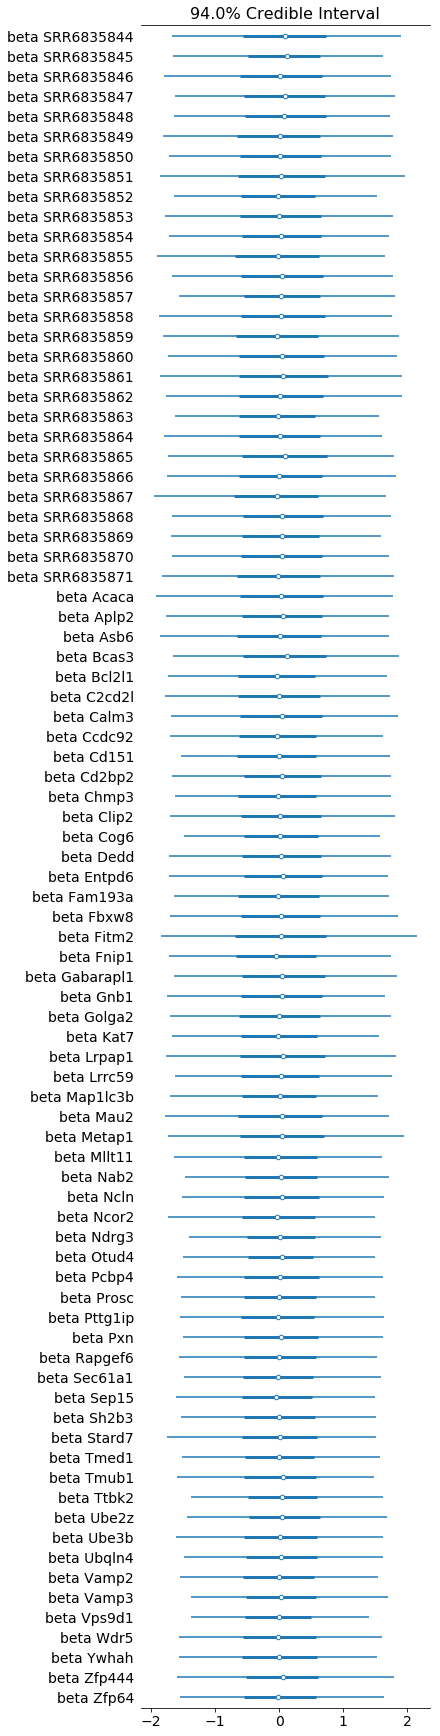

In [102]:
az.plot_forest(traz_fe_gr, var_names=['beta'], figsize=(6,24))
plt.show()

In [103]:
mu_all_hat = np.mean(sample_fe_gr['mu_all'])
sigma_all_hat = np.mean(sample_fe_gr['sigma_all'])
beta_hat = np.mean(sample_fe_gr['beta'], axis=0)

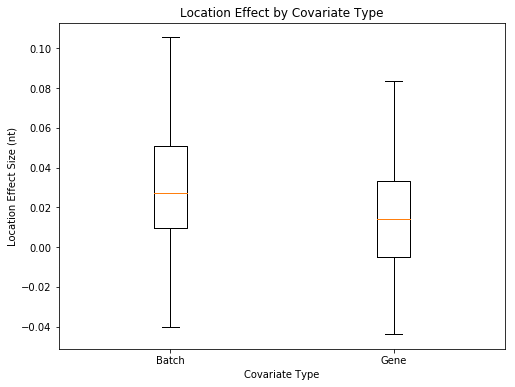

In [104]:
plt.figure(figsize=(8,6))
plt.boxplot([beta_hat[:28], beta_hat[28:]], labels=['Batch', 'Gene'])
plt.title("Location Effect by Covariate Type")
plt.xlabel("Covariate Type")
plt.ylabel("Location Effect Size (nt)")
plt.show()

In [105]:
cutoff_95 = np.empty((B, G))

a_all = sigma_all_hat
b_all = mu_all_hat

for i in range(B):
    b_i = beta_hat[i]
    
    for j in range(G):
        b_j = beta_hat[B + j]
        a, scale = gamma_reparam(b_all + b_i + b_j, a_all)
        
        cutoff_95[i, j] = stats.gamma(a=a, scale=scale).isf(0.05)

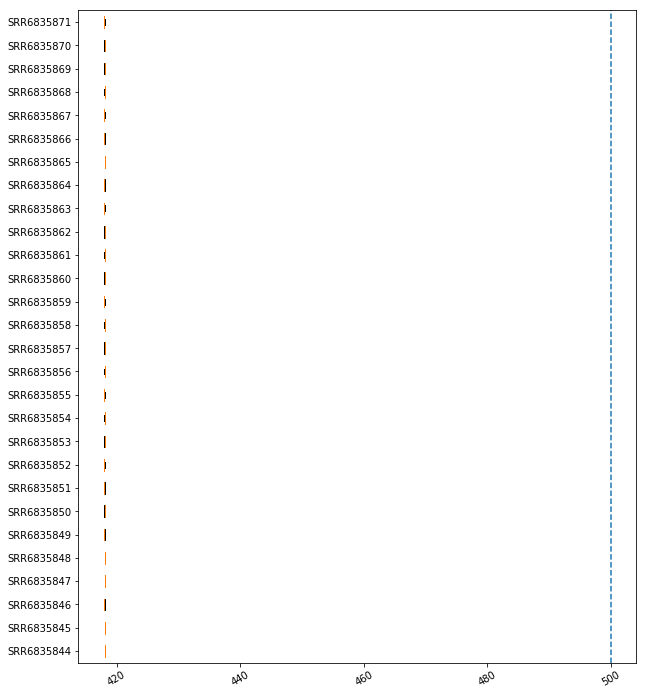

In [106]:
plt.figure(figsize=(10,12))
plt.boxplot(cutoff_95.T, labels=batch_coords, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

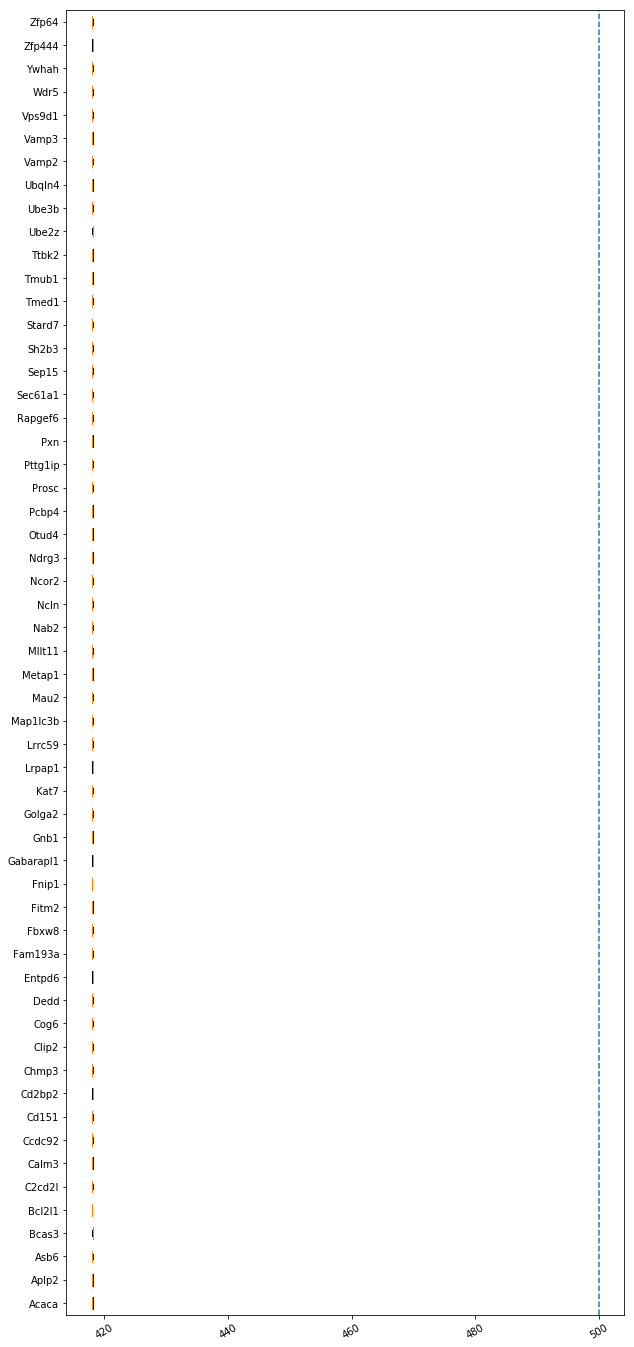

In [107]:
plt.figure(figsize=(10,24))
plt.boxplot(cutoff_95, labels=gene_coords, vert=False)
plt.xticks(rotation=30)
plt.axvline(500, linestyle='--')

plt.show()

# Save Data

In [108]:
import pickle

In [109]:
# aggregated batch model
az.save_data(traz_fe_b_gr, "results/arviz.fixed.batch.gammareg.vi.netcdf")
az.save_data(traz_fe_g_gr, "results/arviz.fixed.gene.gammareg.vi.netcdf")
az.save_data(traz_fe_gr, "results/arviz.fixed.full.gammareg.vi.netcdf")

'results/arviz.fixed.full.gammareg.vi.netcdf'